# Similarity testing pipeline

-----

##### Imports

In [1]:
from functools import partial

from ariel_experiments.gui_vis.visualize_data import create_histogram_from_raw
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.utils.initialize import (
    generate_random_population_parallel,
)

from ariel_experiments.characterize.population import (
    # AnalyzedPopulation,
    get_full_analyzed_population,
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
    get_derived_population_properties,
)

from ariel_experiments.characterize.population import (
    derive_matrix_numerics,
    matrix_derive_neighbourhood,
    get_full_analyzed_population,
    derive_numeric_summary,
)
from ariel_experiments.gui_vis.gui import (
    IndividualVisualizer,
)
from ariel_experiments.gui_vis.gui_simple import (
    SimpleNavigator,
)

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph

import seaborn as sns
import numpy as np
import plotly.graph_objects as go

import networkx as nx

from ariel_experiments.gui_vis.view_mujoco import view

import matplotlib.pyplot as plt

objc[88495]: Class GLFWHelper is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x16990fa28) and /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x17231dbb8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[88495]: Class GLFWApplicationDelegate is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x16990fa78) and /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x17231dc08). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[88495]: Class GLFWWindowDelegate is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-3

##### constants/globals

In [2]:
from rich.console import Console

console = Console()

In [3]:
def plot_two_mujocos(
    graph1: nx.DiGraph, graph2: nx.DiGraph, name_list: list[str] | None = None
):
    img1 = view(graph1, return_img=True)
    img2 = view(graph2, return_img=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    ax1.imshow(img1)
    if name_list:
        ax1.set_title(name_list[0])
    ax1.axis("off")

    ax2.imshow(img2)
    if name_list:
        ax2.set_title(name_list[1])
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
def plot_matrix_distribution(
    matrix: np.ndarray,
    triangle: str = "upper",
    include_diagonal: bool = False,
    cmap: str = "viridis",
    bins: int = 190,
    figsize: tuple[int, int] = (14, 6),
    title_prefix: str = "",
):
    """Plot matrix heatmap and value distribution side by side."""

    # Extract triangle values
    k_offset = 1 if not include_diagonal else 0

    if triangle.lower() == "upper":
        values = matrix[np.triu_indices_from(matrix, k=k_offset)]
        mask = np.tril(np.ones_like(matrix, dtype=bool), k=k_offset - 1)
        triangle_name = "Upper"
    elif triangle.lower() == "lower":
        values = matrix[np.tril_indices_from(matrix, k=-k_offset)]
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=-k_offset + 1)
        triangle_name = "Lower"
    else:
        raise ValueError("triangle must be 'upper' or 'lower'")

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot heatmap
    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[0],
        cmap=cmap,
        square=True,
        cbar_kws={"label": "Value"},
    )
    diag_text = "with" if include_diagonal else "without"
    axes[0].set_title(
        f"{title_prefix}{triangle_name} Triangle Heatmap\n({diag_text} diagonal)"
    )
    axes[1].hist(
        values, bins=bins, alpha=0.7, edgecolor="black", color="steelblue"
    )
    axes[1].axvline(
        np.mean(values),
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"Mean: {np.mean(values):.3f}",
    )
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"{title_prefix}Value Distribution (n={len(values)})")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Add statistics text
    stats_text = (
        f"Min: {np.min(values):.3f}\n"
        f"Max: {np.max(values):.3f}\n"
        f"Std: {np.std(values):.3f}"
    )
    axes[1].text(
        0.98,
        0.97,
        stats_text,
        transform=axes[1].transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        fontsize=9,
    )

    plt.tight_layout()
    return fig, axes


hyperparams

In [5]:
population_size = 1000
population = generate_random_population_parallel(population_size)

Output()

##### Compute

In [6]:
collection_strategy = ctk.CollectionStrategy.NEIGHBOURHOODS

radius_strategy = ctk.RadiusStrategy.NODE_LOCAL
max_tree_radius = 3

missing_data_mode = ctk.MissingDataMode.TREAT_AS_ZERO

score_strategy = ctk.ScoreStrategy.TANIMOTO

vector_mode = ctk.VectorMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR


similarity_config = ctk.create_similarity_config(
    collection_strategy=collection_strategy,
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    vector_mode=vector_mode,
)

In [7]:
analyzed_population = get_full_analyzed_population(
    population,
    analyzers=[
        partial(analyze_neighbourhood, config=similarity_config),
    ],
    derivers=[],
    n_jobs=-1,  # fastest
    hide_tracker=True,
)
matrix_result = matrix_derive_neighbourhood(
    analyzed_population.raw,
    config=similarity_config,
    symmetric=True,
    n_jobs=-1,
    hide_tracker=False,
)

analyzed_population.derived.update(matrix_result)

Computing neighbourhood:   0%|          | 0/100 [00:00<?, ?batch/s]

In [8]:
analyzed_population.show_tree()

AnalyzedPopulation — props=1 derived_keys=2
├── raw
│   └── neighbourhood: len=1000, type=dict
└── derived
    ├── neighbourhood
    │   └── (no derived)
    └── similarity_matrix
        └── full

In [9]:
matrix = analyzed_population.derived["similarity_matrix"]["full"]
np.fill_diagonal(matrix, 0)

In [10]:
# matrix_normalized = (matrix - matrix.min()) / (matrix.max() - matrix.min()) * 100
# matrix = matrix_normalized

In [11]:
upper_triu_idx = np.triu_indices_from(matrix, k=1)
vals = matrix[upper_triu_idx]

-----

### Results

##### Quick overview

Mean: 0.086
Median: 0.086
Min: 0.005
Max: 0.229
Std: 0.020

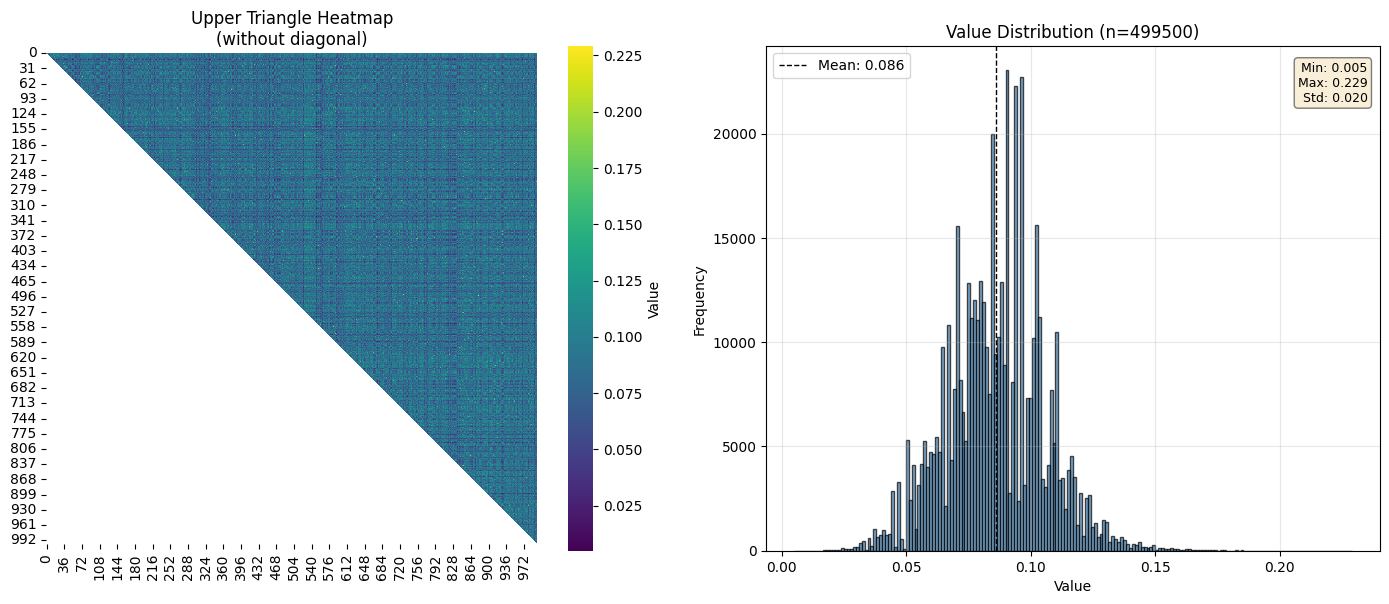

In [12]:
console.print(
    f"Mean: {np.mean(vals):.3f}\nMedian: {np.median(vals):.3f}\nMin: {np.min(vals):.3f}\nMax: {np.max(vals):.3f}\nStd: {np.std(vals):.3f}"
)

fig, axes = plot_matrix_distribution(matrix)
plt.show()

##### Highest similarity-pairs

In [13]:
N = 20
if vals.size == 0:
    top = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(-vals, k)[:k]  # top k (unsorted)
    sel = sel[np.argsort(-vals[sel])]  # sorted desc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    top = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# top is a list of (row, col, value) tuples sorted by value desc
console.print(top)

iterator = 0

[
    (200, 944, 0.2290000021457672),
    (310, 756, 0.22699999809265137),
    (168, 449, 0.22100000083446503),
    (100, 767, 0.21899999678134918),
    (388, 765, 0.2070000022649765),
    (743, 918, 0.2070000022649765),
    (438, 554, 0.20399999618530273),
    (93, 911, 0.20399999618530273),
    (122, 495, 0.20399999618530273),
    (841, 919, 0.20399999618530273),
    (203, 810, 0.2029999941587448),
    (491, 727, 0.2029999941587448),
    (493, 880, 0.20100000500679016),
    (114, 153, 0.20100000500679016),
    (423, 693, 0.20000000298023224),
    (367, 508, 0.19900000095367432),
    (324, 860, 0.19900000095367432),
    (310, 714, 0.19900000095367432),
    (338, 791, 0.19699999690055847),
    (140, 243, 0.19699999690055847)
]

keep pressing this notebook cell to iterate over the robots

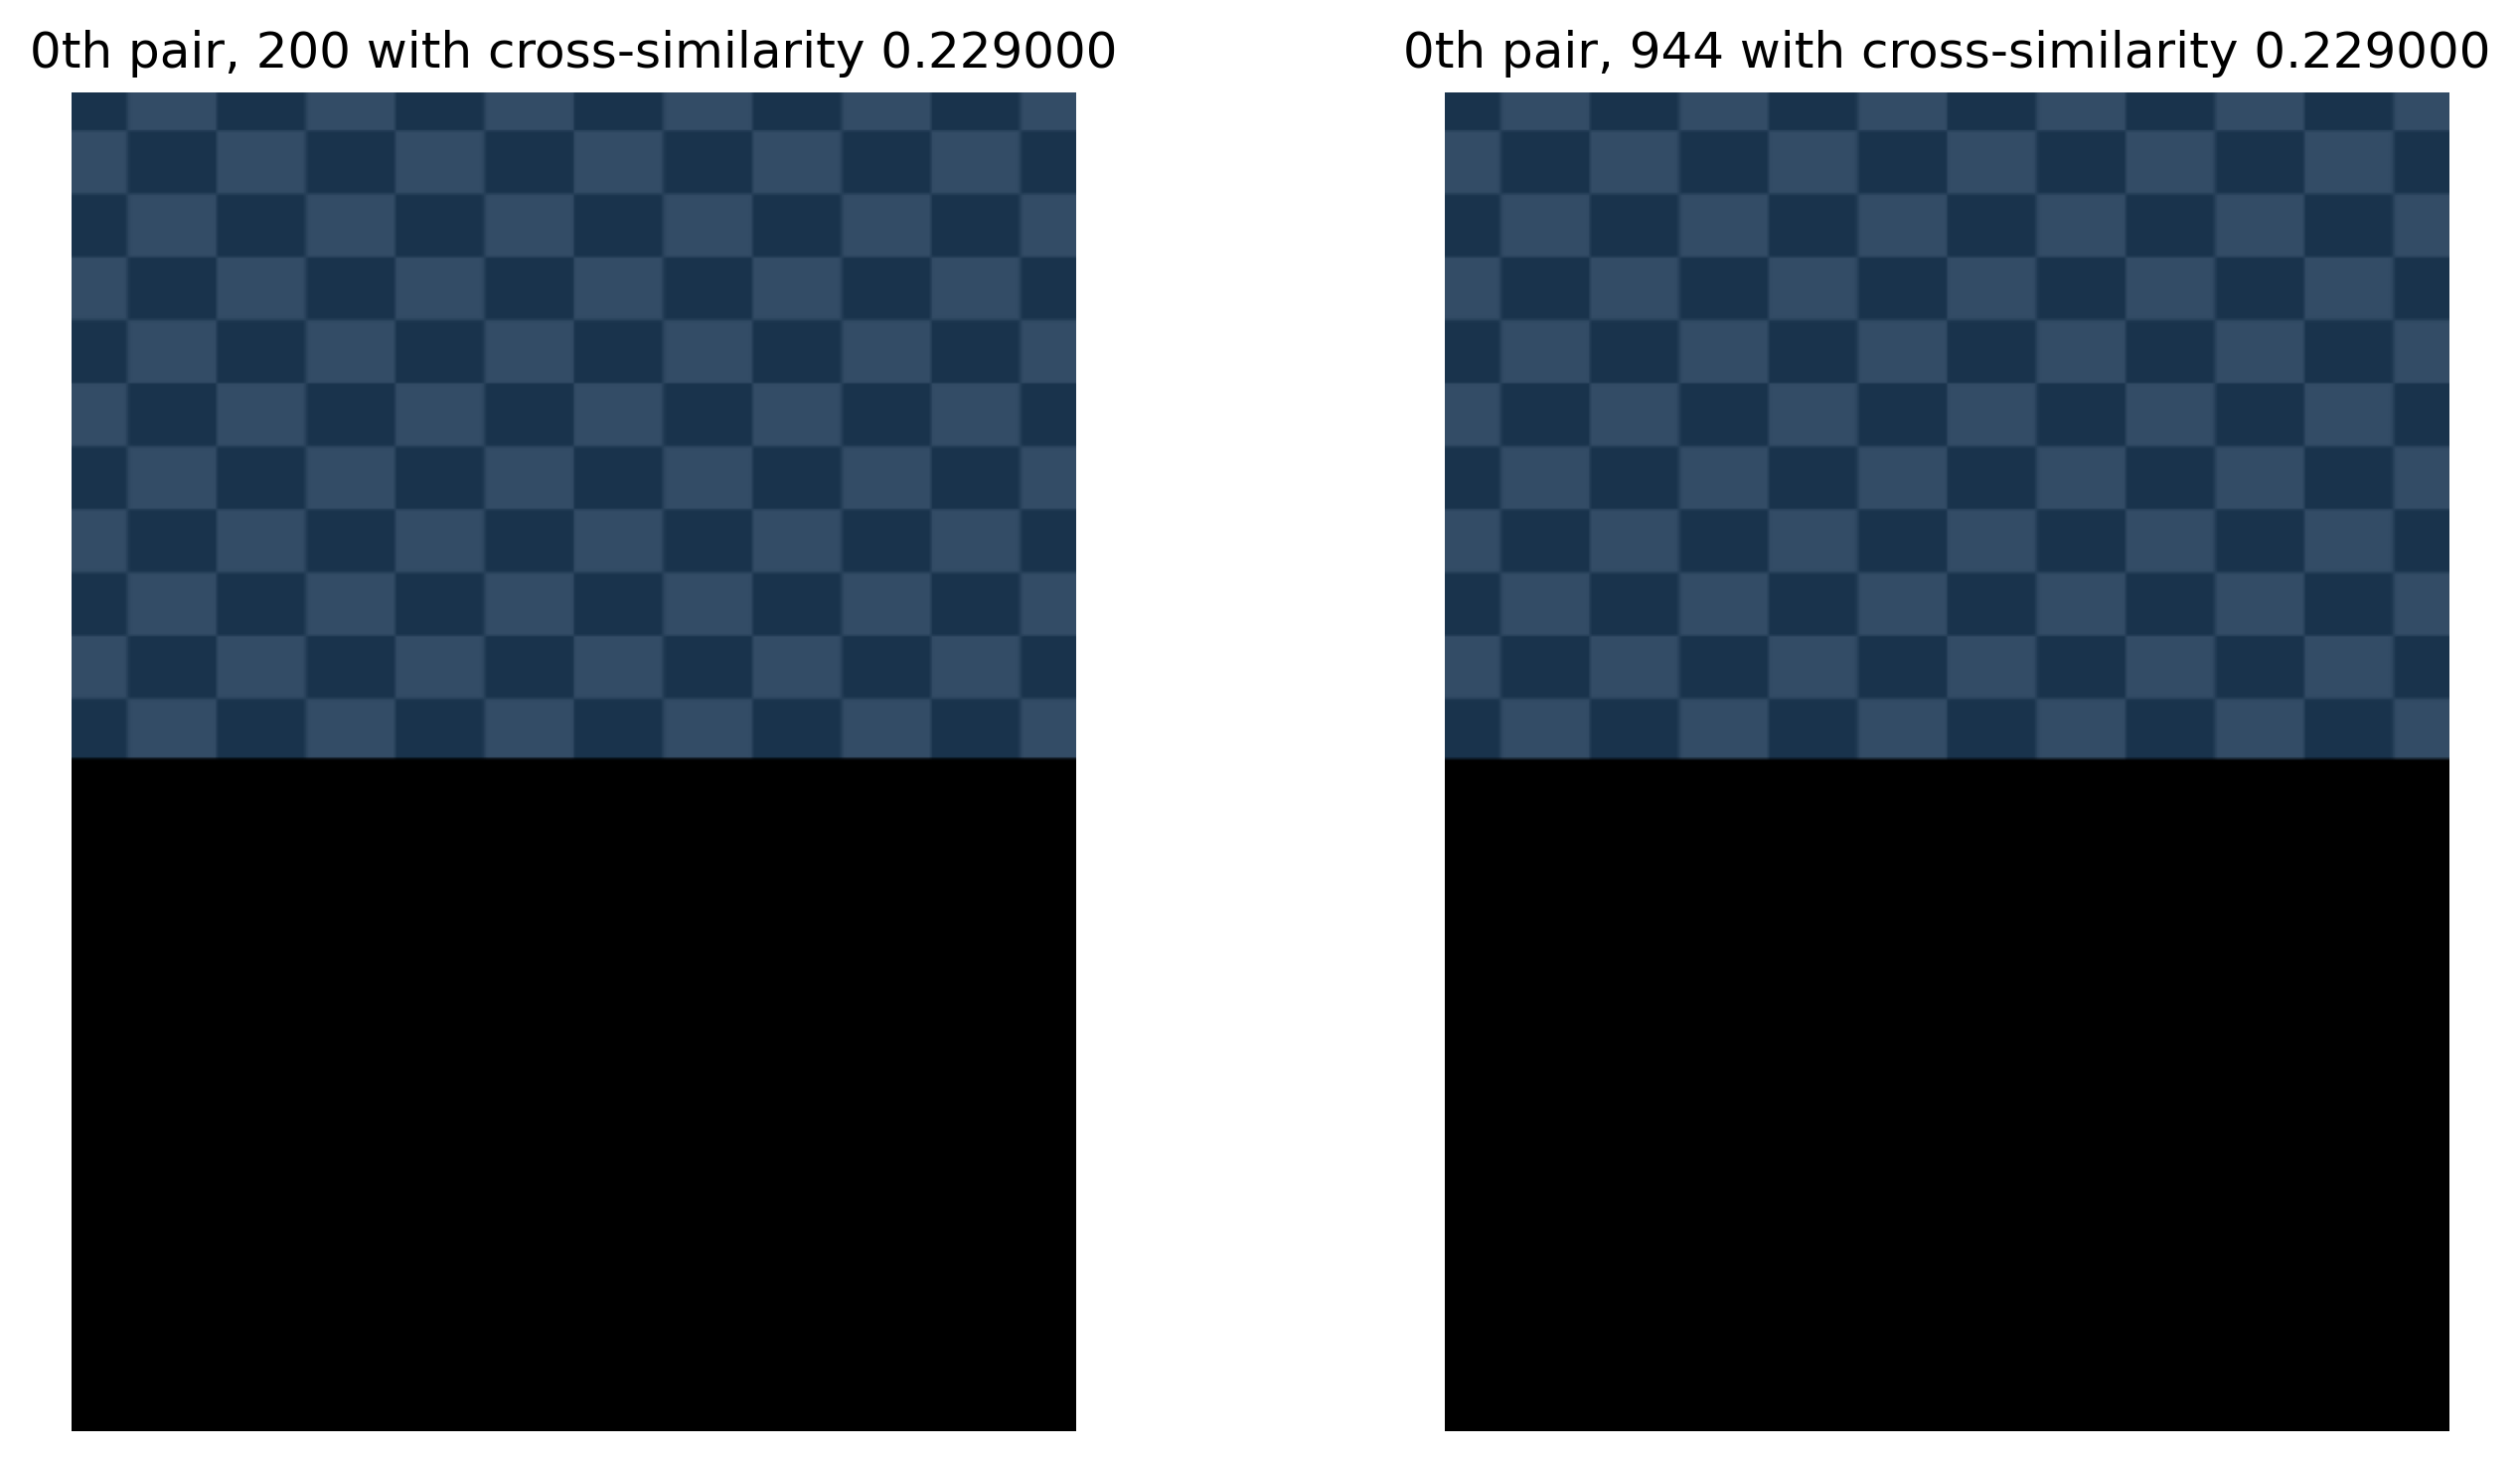

SimilarityResults(
    similarity_value=0.23966109253065776,
    tree_hash_dicts=(
        {
            0: ['C', 'B', 'B', 'B', 'B', 'H', 'H', 'H', 'H', 'H', 'B', 'H', 'B', 'H'],
            1: [
                'C[r(B1)]',
                'C[r(B1[t(B)]B1)]',
                'BB1[l(B)]',
                'B[l(BB)]',
                'BBH3',
                'BH3H',
                'HHH2',
                'HH2H2',
                'HH2H2',
                'HH2',
                'B[l(B[t(B1)]H1)]',
                'BH1',
                'B[l(B1H3)]',
                'BH3'
            ],
            2: [
                'C[r(B1[t(B)]B1)]',
                'C[r(B1[t(B[r(B1)]H3)]B1[l(B)])]',
                'C[r(B1[t(B)]B1[l(BB)])]',
                'BB1[l(BBH3)]',
                'B[l(BBH3H)]',
                'BBH3HH2',
                'BH3HH2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'HH2H2',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'B[l(B[t(B1)]H1)]',
                'B[l(B[t(B1H1)]H1)]',
                'B[l(B1H3)]'
            ],
            3: [
                'C[r(B1[t(B[r(B1)]H3)]B1[l(B)])]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1[l(BB)])]',
                'C[r(B1[t(B[r(B1)]H3)]B1[l(BBH3)])]',
                'C[r(B1[t(B)]B1[l(BBH3H)])]',
                'BB1[l(BBH3HH2)]',
                'B[l(BBH3HH2H2)]',
                'BBH3HH2H2H2',
                'BH3HH2H2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'C[r(B1[t(B[r(B1H3)]H3)]B1[l(B)])]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'B[l(B[t(B1H1)]H1)]'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'H', 'H', 'H', 'H', 'H', 'B', 'B', 'H', 'B', 'H'],
            1: [
                'C[r(B)b(H3)]',
                'C[r(B[l(B)])]',
                'B[l(B[l(B)t(B1)])]',
                'B[l(B[r(B1)]B)]',
                'BB[t(B)]H3',
                'BH3H',
                'HHH2',
                'HH2H2',
                'HH2H2',
                'HH2',
                'B[l(B)]',
                'B[l(B1H1)]',
                'BH1',
                'B[l(B1)]',
                'C[r(H3)]'
            ],
            2: [
                'C[f(B[l(B)])r(H3)]',
                'C[r(B[l(B[l(B)t(B1)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])]',
                'B[l(B[r(B1)]B[t(B)]H3H)]',
                'BB[t(B)]H3HH2',
                'BH3HH2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'HH2H2',
                'BB[t(B)]H3',
                'B[l(B[r(B1H1)]B)]',
                'B[l(B1H1)]',
                'B[l(B[l(B)t(B1)])]',
                'C[f(B)r(H3)]'
            ],
            3: [
                'C[r(B[l(B[l(B)t(B1)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3H)])])]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3HH2)])]',
                'B[l(B[r(B1)]B[t(B)]H3HH2H2)]',
                'BB[t(B)]H3HH2H2H2',
                'BH3HH2H2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'B[l(B[r(B1)]B[t(B)]H3H)]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])]',
                'B[l(B[r(B1H1)]B)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])]',
                'C[r(B[l(B)])b(H3)]'
            ]
        }
    ),
    per_radius_vectors={
        0: (HashVector(
    B: 6.000
    C: 1.000
    H: 7.000
), HashVector(
    B: 7.000
    C: 1.000
    H: 7.000
)),
        1: (
            HashVector(
           BB1[l(B)]: 1.000
                BBH3: 1.000
                 BH1: 1.000
                 BH3: 1.000
                BH3H: 1.000
          B[l(B1H3)]: 1.000
            B[l(BB)]: 1.000
    B[l(B[t(B1)]H1)]: 1.000
  

In [14]:
node1 = ctk.from_graph(population[top[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[top[int(iterator)][1]]).canonicalize()

plot_two_mujocos(
    node1.to_graph(),
    node2.to_graph(),
    [
        f"{iterator}th pair, {top[int(iterator)][0]} with cross-similarity {[top[int(iterator)][2]][0]:2f}",
        f"{iterator}th pair, {top[int(iterator)][1]} with cross-similarity {[top[int(iterator)][2]][0]:2f}",
    ],
)

results = ctk.calculate_similarity(
    node1, node2, config=similarity_config, return_all=True
)
console.print(results)

iterator = (iterator + 1) % N

##### Lowest similarity-pairs

In [15]:
N = 20

if vals.size == 0:
    bottom = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(vals, k)[:k]  # bottom k (unsorted)
    sel = sel[np.argsort(vals[sel])]  # sorted asc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    bottom = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# bottom is a list of (row, col, value) tuples sorted by value asc (lowest first)
console.print(bottom)
iterator = 0

[
    (298, 897, 0.004999999888241291),
    (149, 298, 0.010999999940395355),
    (550, 897, 0.010999999940395355),
    (172, 897, 0.010999999940395355),
    (298, 801, 0.012000000104308128),
    (237, 897, 0.014000000432133675),
    (298, 523, 0.014000000432133675),
    (298, 994, 0.014000000432133675),
    (298, 842, 0.014999999664723873),
    (298, 760, 0.014999999664723873),
    (793, 897, 0.014999999664723873),
    (712, 897, 0.014999999664723873),
    (485, 897, 0.01600000075995922),
    (558, 897, 0.01600000075995922),
    (38, 897, 0.01600000075995922),
    (850, 897, 0.01600000075995922),
    (298, 332, 0.01600000075995922),
    (298, 642, 0.017000000923871994),
    (298, 562, 0.017000000923871994),
    (573, 897, 0.017000000923871994)
]

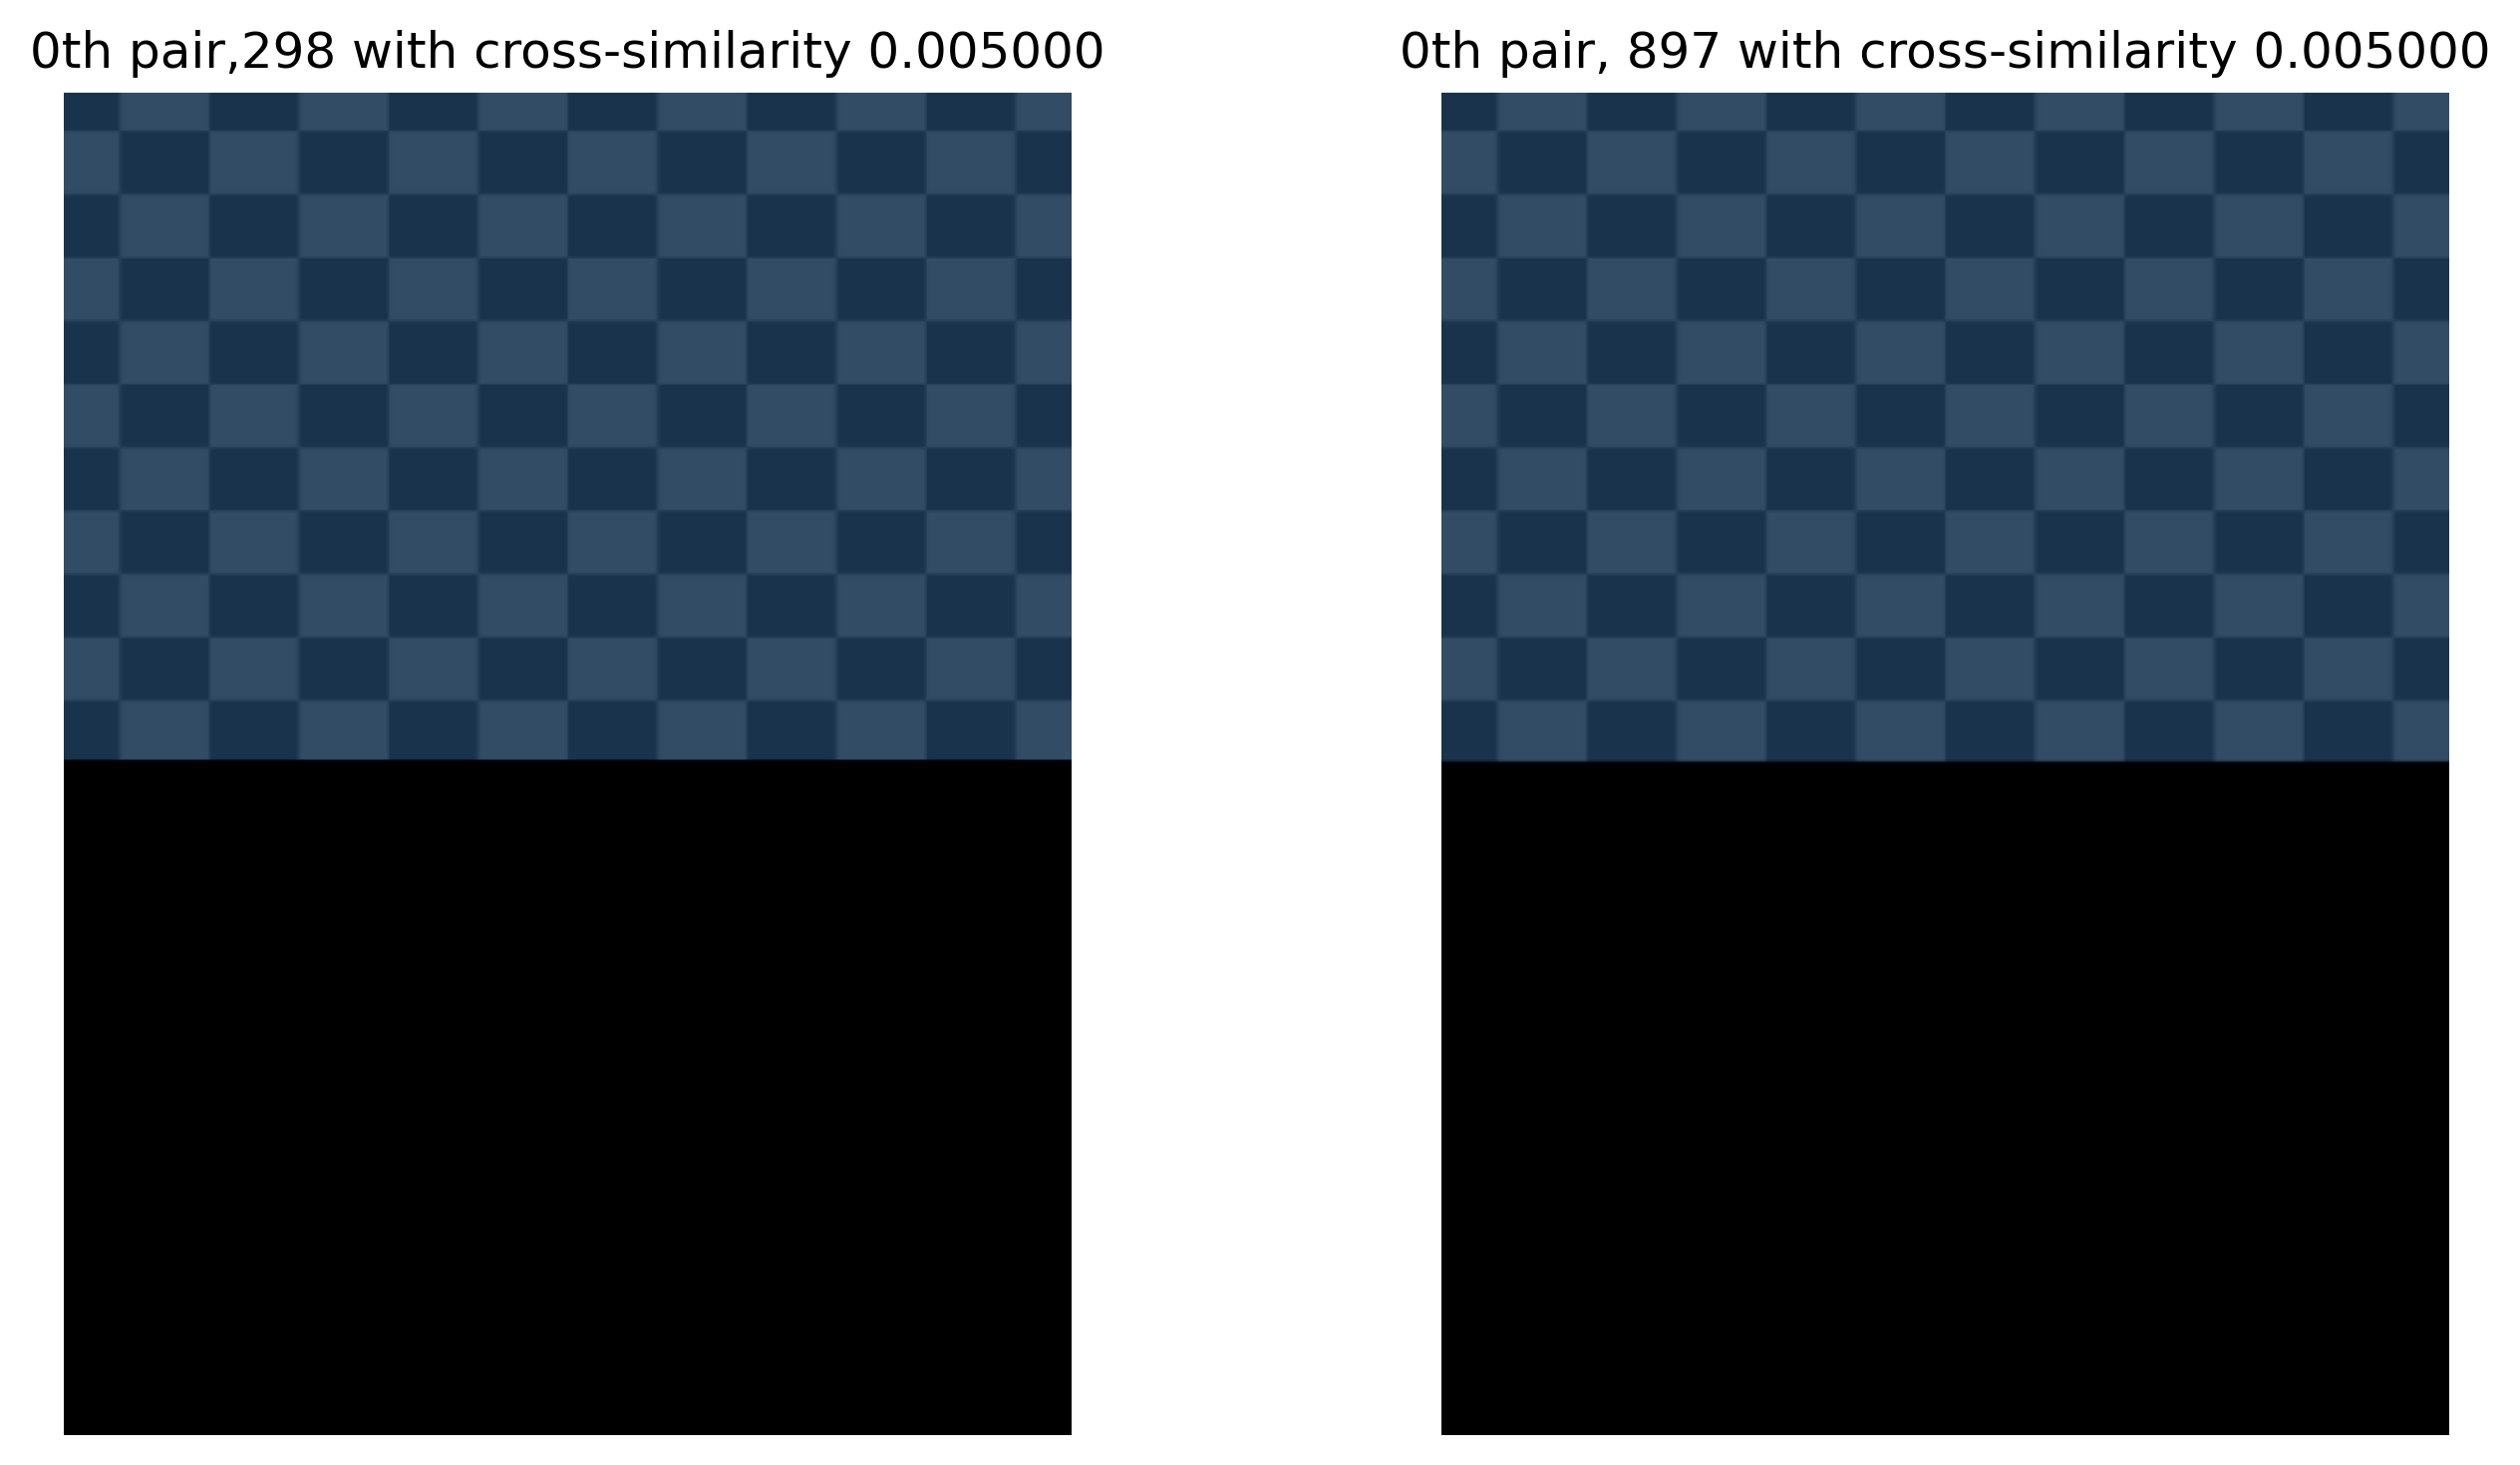

SimilarityResults(
    similarity_value=0.005,
    tree_hash_dicts=(
        {
            0: ['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
            1: ['C[r(H3)]', 'C[r(H3H)]', 'HHH1', 'HH1H3', 'HH3H3', 'HH3H', 'HHH3', 'HH3H2', 'HH2H', 'HH'],
            2: [
                'C[r(H3H)]',
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'HHH1H3H3',
                'HH1H3H3H',
                'HH3H3HH3',
                'HH3HH3H2',
                'HHH3H2H',
                'HH3H2H',
                'HH2H'
            ],
            3: [
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'C[r(H3HH1H3H3)]',
                'C[r(H3HH1H3H3H)]',
                'HHH1H3H3HH3',
                'HH1H3H3HH3H2',
                'HH3H3HH3H2H',
                'HH3HH3H2H',
                'HHH3H2H',
                'HH3H2H'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
            1: [
                'C[rl(B)]',
                'C[r(BB)]',
                'BB[rt(B)]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B)]',
                'B[l(B1)]',
                'B[l(B[t(B)])]',
                'B[l(B[r(B1)])]',
                'B[l(B1[t(B1)])]',
                'B[l(B1)]',
                'C[r(B)]'
            ],
            2: [
                'C[r(B)l(BB)]',
                'C[l(B)r(BB[rt(B)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'BB[r(B)t(B[r(B[l(B1)])])]',
                'B[l(B[t(B[b(B1[r(B1)])])])]',
                'B[l(B[r(B1[b(B1)])])]',
                'B[l(B1[t(B1)])]',
                'C[rl(B)]'
            ],
            3: [
                'C[l(B)r(BB[rt(B)])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1)])])])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1[t(B1)])])])])]',
                'BB[r(B)t(B[r(B[l(B1[t(B1)])])])]',
                'B[l(B[t(B[b(B1[r(B1)])])])]',
                'B[l(B[r(B1[b(B1)])])]',
                'C[l(B)r(BB)]'
            ]
        }
    ),
    per_radius_vectors={
        0: (HashVector(
    C: 1.000
    H: 9.000
), HashVector(
    B: 10.000
    C: 1.000
)),
        1: (
            HashVector(
     C[r(H3)]: 1.000
    C[r(H3H)]: 1.000
           HH: 1.000
        HH1H3: 1.000
         HH2H: 1.000
         HH3H: 1.000
        HH3H2: 1.000
        HH3H3: 1.000
         HHH1: 1.000
         HHH3: 1.000
),
            HashVector(
             BB[rt(B)]: 1.000
               B[l(B)]: 1.000
              B[l(B1)]: 2.000
       B[l(B1[t(B1)])]: 1.000
    B[l(B[r(B)b(B1)])]: 1.000
        B[l(B[r(B1)])]: 1.000
         B[l(B[t(B)])]: 1.000
               C[r(B)]: 1.000
              C[r(BB)]: 1.000
              C[rl(B)]: 1.000
)
        ),
        2: (
            HashVector(
        C[r(H3H)]: 1.000
      C[r(H3HH1)]: 1.000
    C[r(H3HH1H3)]: 1.000
         HH1H3H3H: 1.000
             HH2H: 1.000
           HH3H2H: 1.000
         HH3H3HH3: 1.000
         HH3HH3H2: 1.000
         HHH1H3H3: 1.000
          HHH3H2H: 1.000
),
            HashVector(
              BB[r(B)t(B[r(B[l(B1)])])]: 1.000
                BB[t(B)r(B[l(B)t(B1)])]: 1.000
                        B[l(B1[t(B1)])]: 1.000
                     B[l(B[r(B)b(B1)])]: 2.000
                  B[l(B[r(B1[b(B1)])])]: 1.000
            B[l(B[t(B[b(B1[r(B1)])])])]: 1.000
                    C[l(B)r(BB[rt(B)])]: 1.000
                           C[r(B)l(BB)]: 1.000
    C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]: 1.000
                               C[rl(B)]: 1.000
)
        ),
        3: (
            HashVector(
         C[r(H3HH1)]: 1.000

In [16]:
node1 = ctk.from_graph(population[bottom[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[bottom[int(iterator)][1]]).canonicalize()

plot_two_mujocos(
    node1.to_graph(),
    node2.to_graph(),
    [
        f"{iterator}th pair,{bottom[int(iterator)][0]} with cross-similarity {[bottom[int(iterator)][2]][0]:2f}",
        f"{iterator}th pair, {bottom[int(iterator)][1]} with cross-similarity {[bottom[int(iterator)][2]][0]:2f}",
    ],
)

results = ctk.calculate_similarity(
    node1, node2, config=similarity_config, return_all=True
)
console.print(results)

iterator = (iterator + 1) % N

-----

Fitness preperation

In [17]:
fitness_array = (matrix.sum(axis=0) - 1) / len(population)
population_fitness = {"diversity_fitness": fitness_array.tolist()}
analyzed_population.raw.update(population_fitness)

deriver_list = [
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
]

new_derived = get_derived_population_properties(
    population_fitness, deriver_list, hide_tracker=True
)

matrix_stats = derive_matrix_numerics(
    analyzed_population.derived, key="similarity_matrix"
)

analyzed_population.derived.update(matrix_stats)
analyzed_population.derived.update(new_derived)

analyzed_population.show_tree()

AnalyzedPopulation — props=2 derived_keys=3
├── raw
│   ├── diversity_fitness: len=1000, type=numeric
│   └── neighbourhood: len=1000, type=dict
└── derived
    ├── diversity_fitness
    │   ├── max_first_idx
    │   ├── min_first_idx
    │   ├── numeric_stats
    │   └── uniques
    ├── neighbourhood
    │   └── (no derived)
    └── similarity_matrix
        ├── full
        ├── matrix_max_first_idx
        ├── matrix_min_first_idx
        └── matrix_stats

##### Most similar and diverse Individuals (as fitness)

In [18]:
tracker = 0

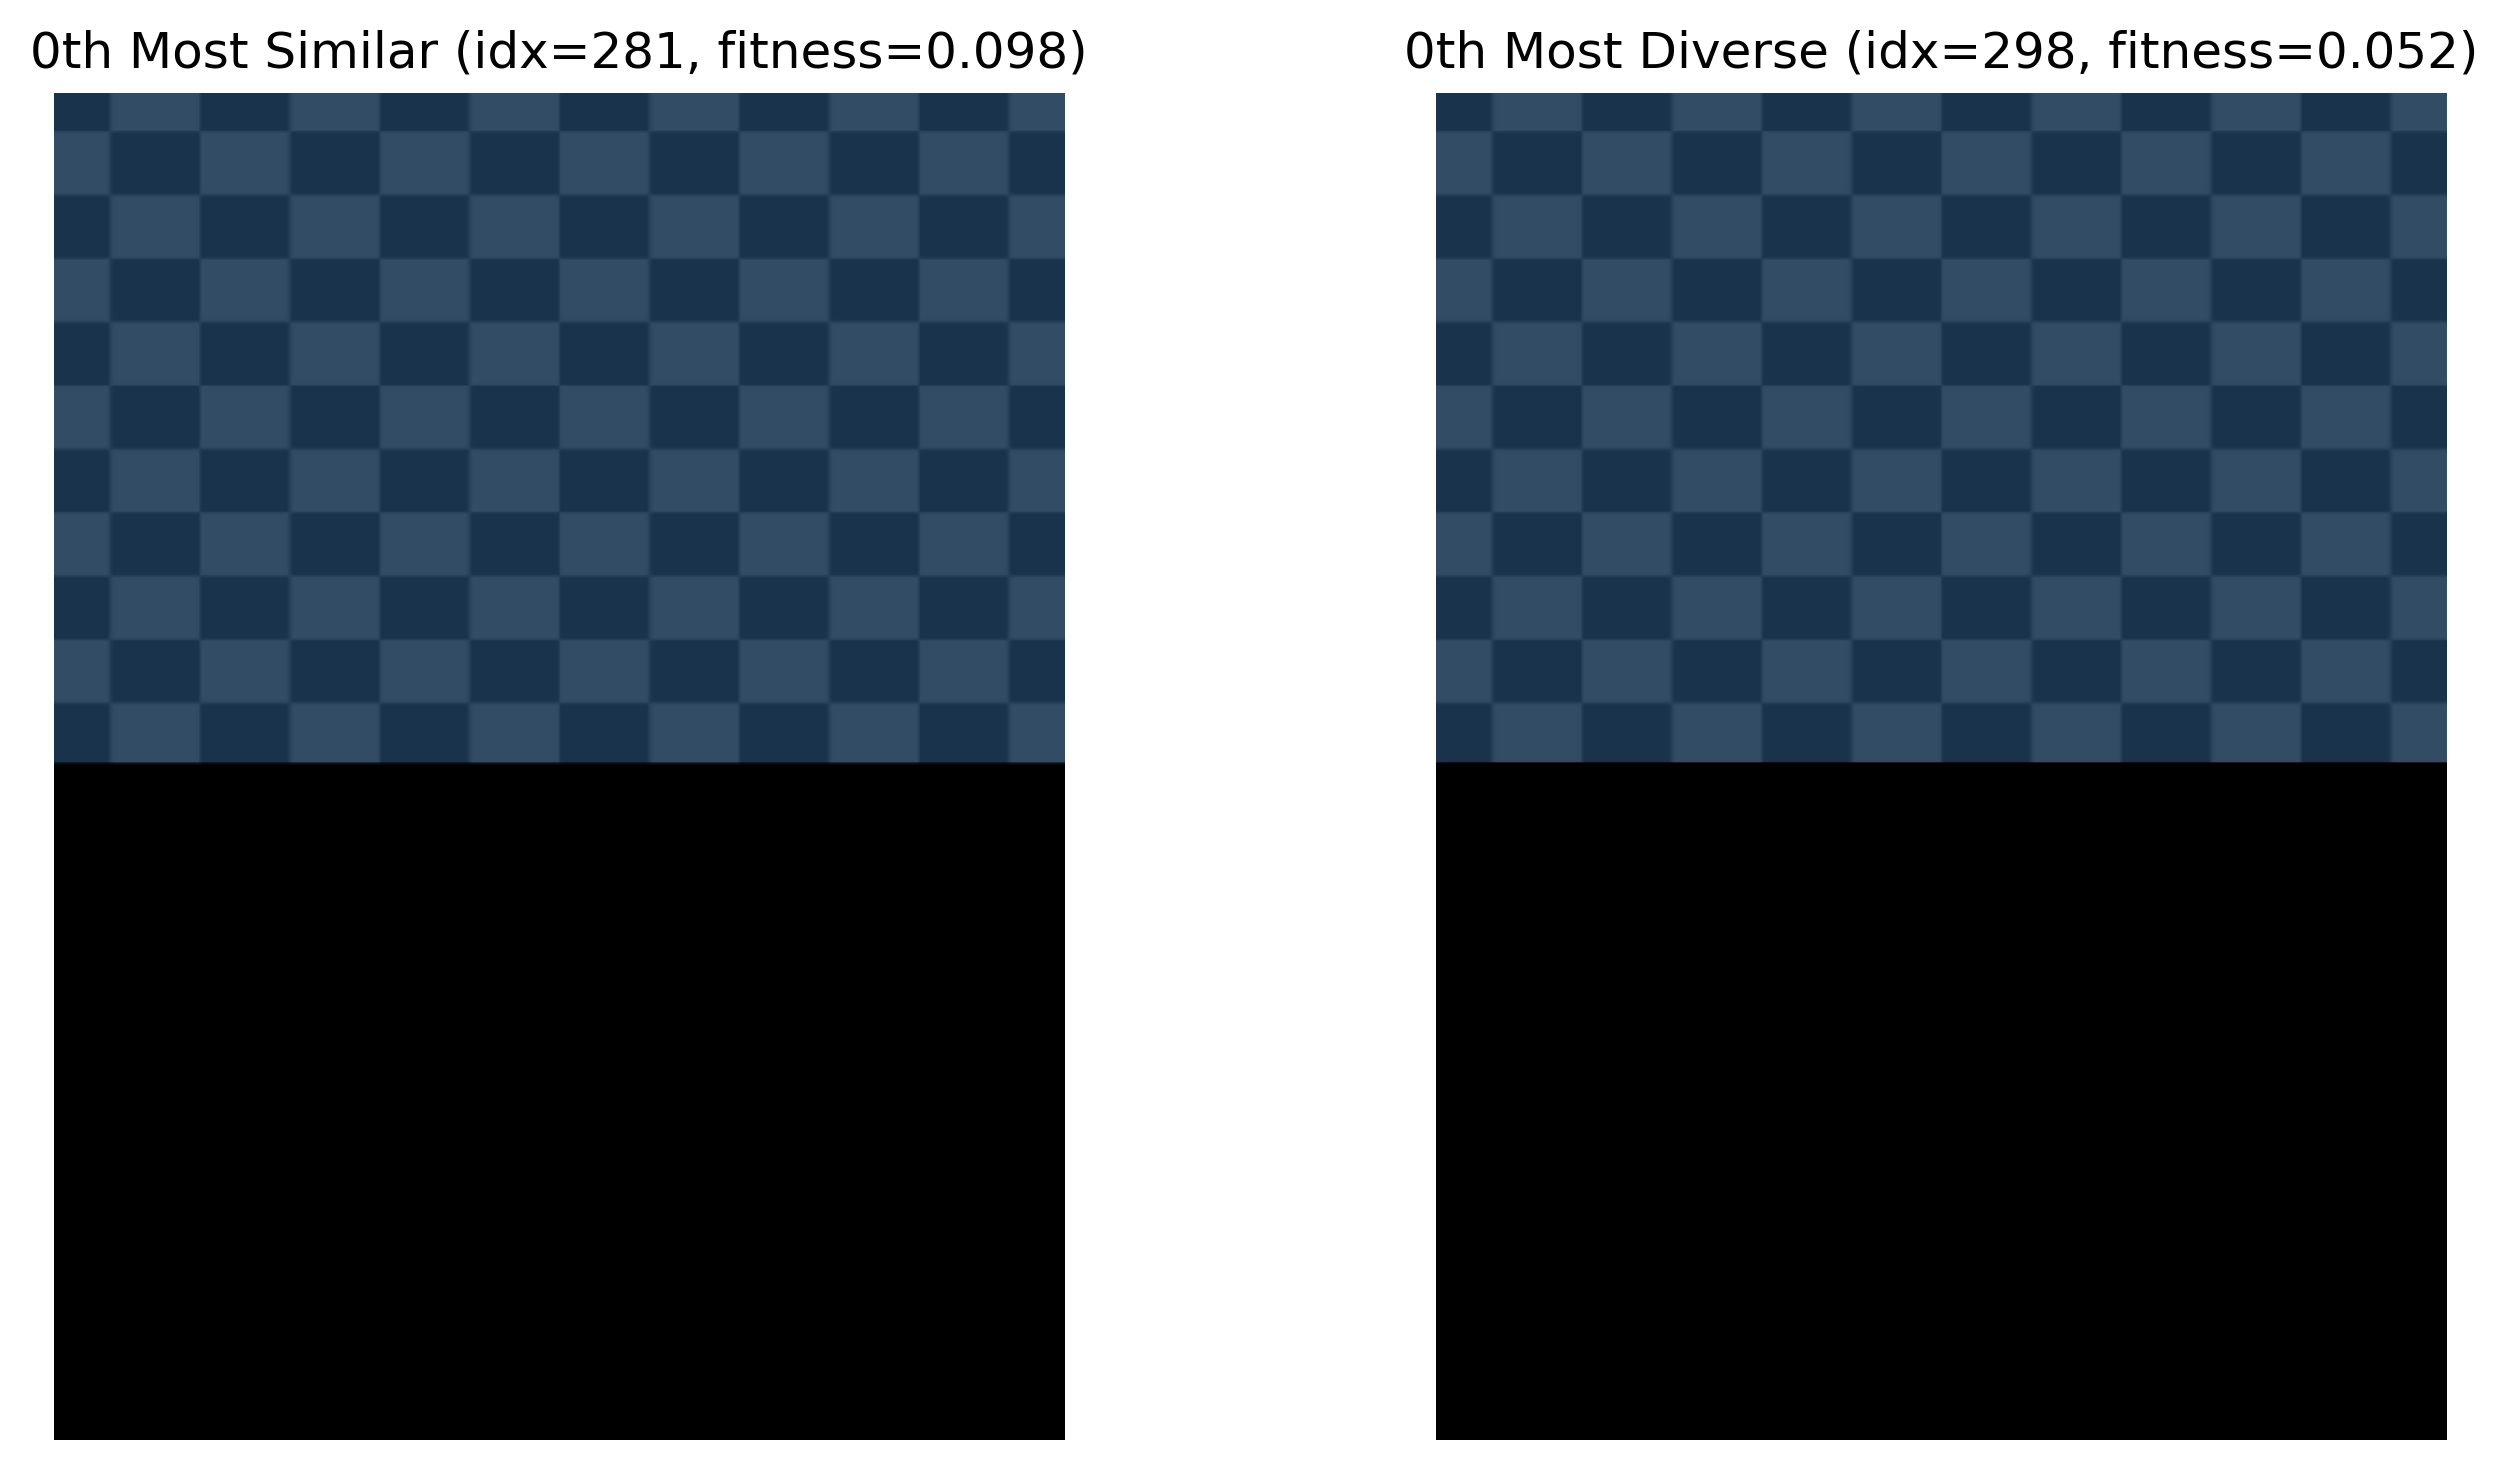

Canonical: C[r(B1[l(B)b(B1)r(B1[r(B1H)b(B1H3H2H3H3)]H3)])] and C[r(H3HH1H3H3HH3H2H)]

Similarity between most similar and most diverse: 0.053

In [19]:
# Get most similar (max diversity fitness)
max_dict = analyzed_population.derived["diversity_fitness"]["max_first_idx"]
max_idx = max_dict["idxs"][tracker]
max_value = max_dict["values"][tracker]

# Get most diverse (min diversity fitness)
min_dict = analyzed_population.derived["diversity_fitness"]["min_first_idx"]
min_idx = min_dict["idxs"][tracker]
min_value = min_dict["values"][tracker]

# Create canonicalized nodes
node_most_similar = ctk.from_graph(population[max_idx]).canonicalize()
node_most_diverse = ctk.from_graph(population[min_idx]).canonicalize()

# Plot side by side
plot_two_mujocos(
    node_most_similar.to_graph(),
    node_most_diverse.to_graph(),
    [
        f"{tracker}th Most Similar (idx={max_idx}, fitness={max_value:.3f})",
        f"{tracker}th Most Diverse (idx={min_idx}, fitness={min_value:.3f})",
    ],
)

console.print(
    f"Canonical: {ctk.to_canonical_string(node_most_similar)} and {ctk.to_canonical_string(node_most_diverse)}",
    markup=False,
    highlight=False,
)

# Calculate similarity between them
similarity = ctk.calculate_similarity(
    node_most_similar, node_most_diverse, config=similarity_config
)
console.print(
    f"\n[yellow]Similarity between most similar and most diverse:[/yellow] {similarity:.3f}"
)

tracker = (tracker + 1) % len(population)

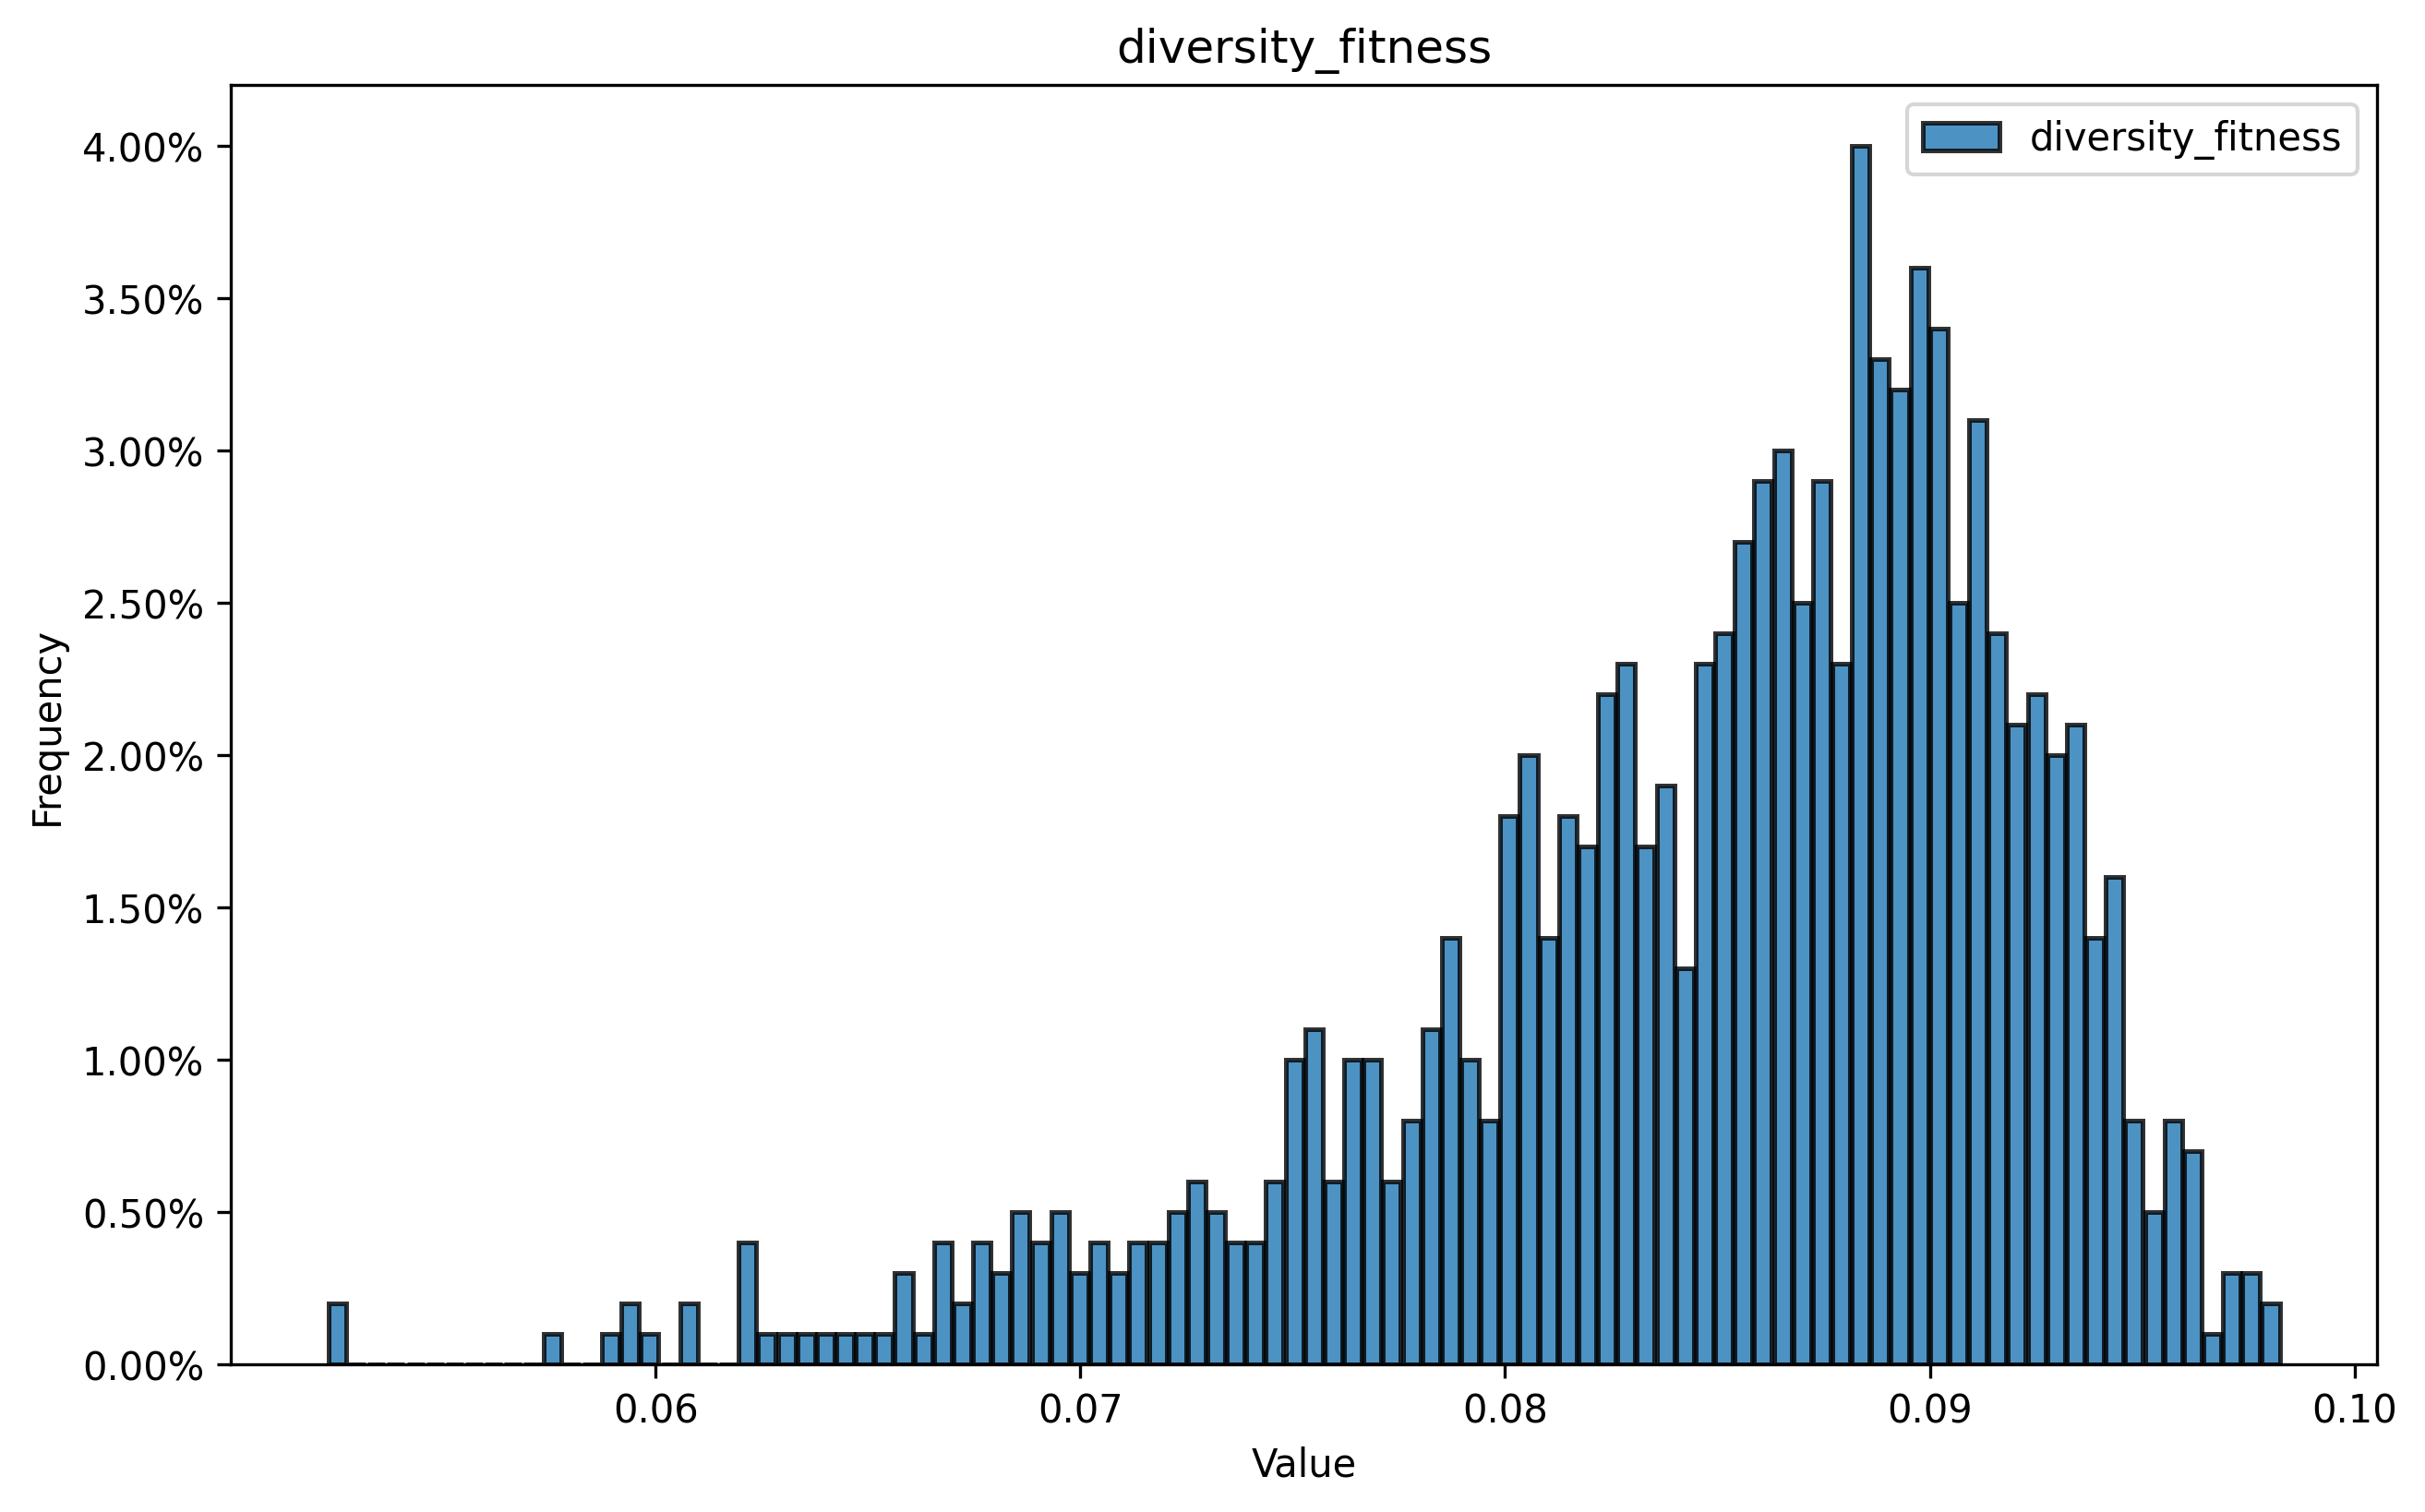

In [20]:
create_histogram_from_raw(
    analyzed_population.raw, keys=["diversity_fitness"], bins=100
)

##### Most similar and diverse Individuals using TF-IDF

In [21]:
tfidf_config = ctk.create_tfidf_config(
    collection_strategy=ctk.CollectionStrategy.NEIGHBOURHOODS,
    radius_strategy=ctk.RadiusStrategy.NODE_LOCAL,
    score_strategy=ctk.ScoreStrategy.TFIDF,
    tfidf_mode=ctk.TFIDFMode.ENTROPY,
    vector_mode=ctk.VectorMode.SET,
    weighting_mode=ctk.WeightingMode.LINEAR,
    missing_data_mode=ctk.MissingDataMode.SKIP_RADIUS,
    tfidf_smooth=False,
    entropy_normalised=False,
    max_tree_radius=3,
)

In [22]:
tfidf_dict = {}
neighboorhood_list = analyzed_population.raw["neighbourhood"]

ctk.update_tfidf_dictionary(neighboorhood_list, tfidf_dict)

In [23]:
tfidf_list = []
for idx, neighboorhood_dict in enumerate(neighboorhood_list):
    tfidf_list.append(
        ctk.calculate_tfidf(neighboorhood_dict, tfidf_dict, config=tfidf_config)
    )

analyzed_population.raw.update({"tfidf": tfidf_list})

In [24]:
deriver_list = [
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
]

tfidf_derived = get_derived_population_properties(
    {"tfidf": tfidf_list}, deriver_list, hide_tracker=True
)

analyzed_population.derived.update(tfidf_derived)

In [25]:
tracker = 0

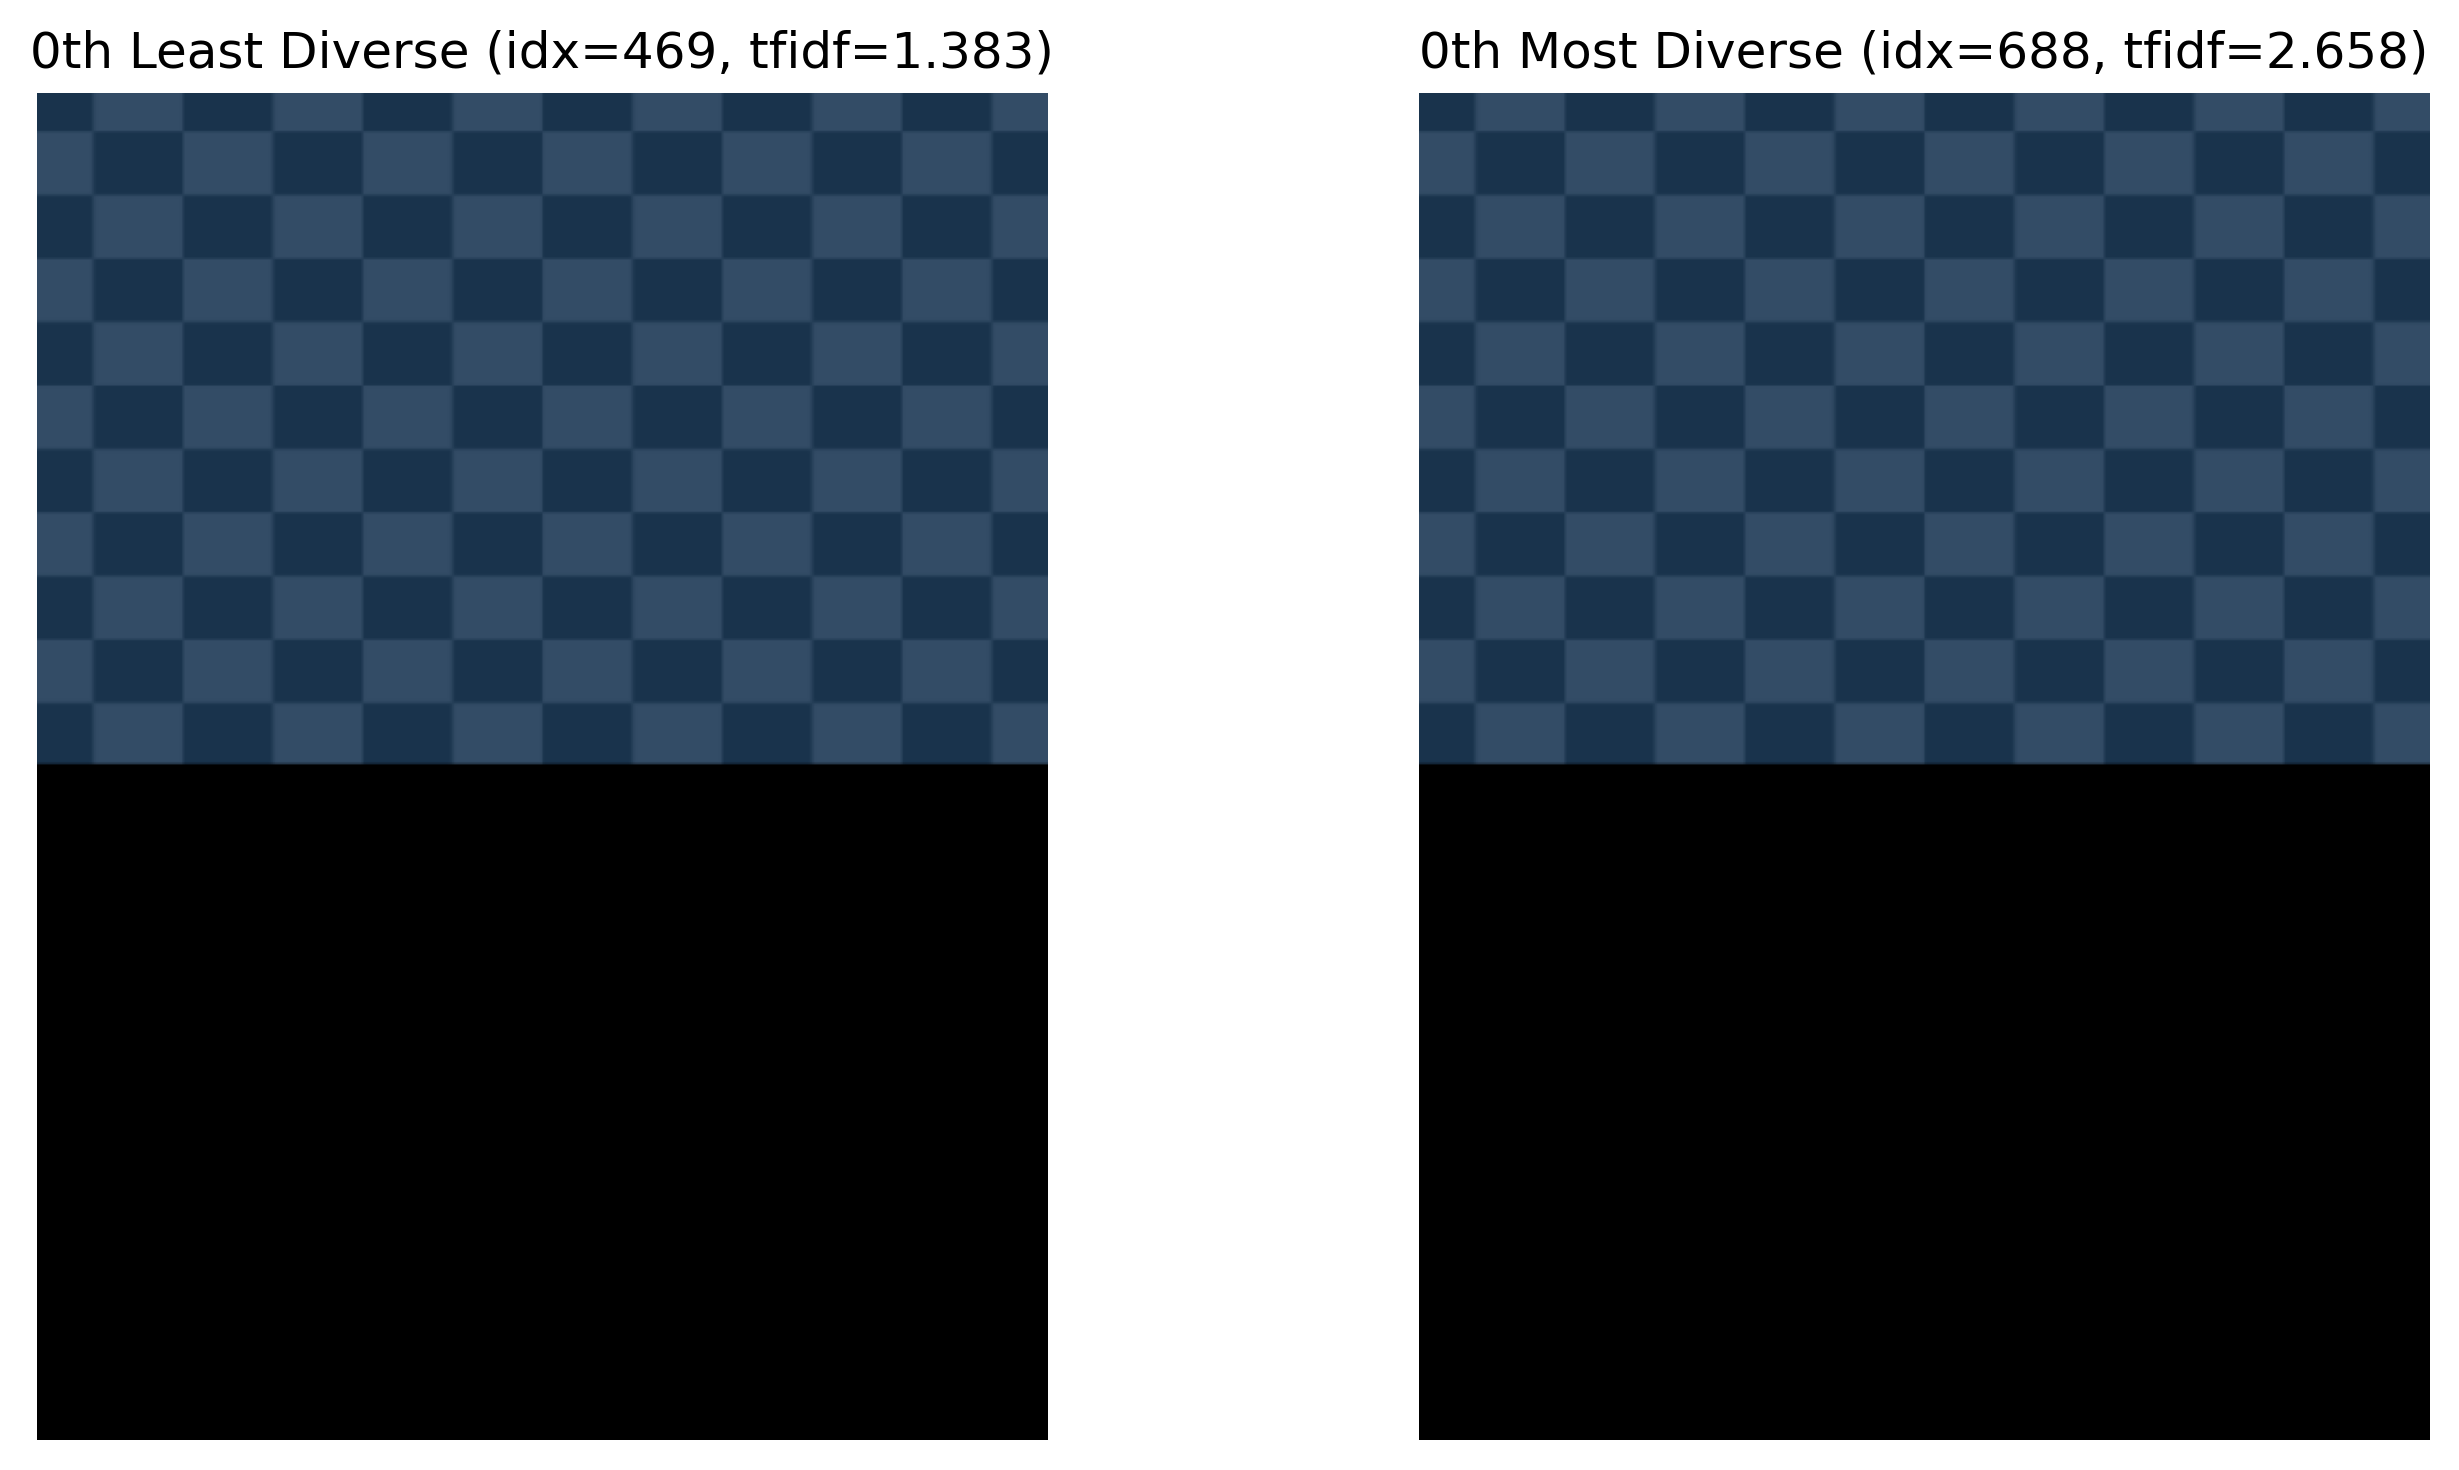

Canonical: C[l(B)r(B1[l(B[b(B)]H2)]H)] and 
C[r(B1[t(B1H3B)]H3H3)]<t(B[t(B1[l(B1H3)t(B1[l(B1[r(B[t(BHH)])])]B1)]H3)])>

Similarity between most similar and most diverse: 0.037

In [26]:
# Get most similar (max diversity fitness)
max_dict = analyzed_population.derived["tfidf"]["max_first_idx"]
max_idx = max_dict["idxs"][tracker]
max_value = max_dict["values"][tracker]

# Get most diverse (min diversity fitness)
min_dict = analyzed_population.derived["tfidf"]["min_first_idx"]
min_idx = min_dict["idxs"][tracker]
min_value = min_dict["values"][tracker]

# Create canonicalized nodes
node_most_similar = ctk.from_graph(population[min_idx]).canonicalize()
node_most_diverse = ctk.from_graph(population[max_idx]).canonicalize()

# Plot side by side
plot_two_mujocos(
    node_most_similar.to_graph(),
    node_most_diverse.to_graph(),
    [
        f"{tracker}th Least Diverse (idx={min_idx}, tfidf={min_value:.3f})",
        f"{tracker}th Most Diverse (idx={max_idx}, tfidf={max_value:.3f})",
    ],
)

console.print(
    f"Canonical: {ctk.to_canonical_string(node_most_similar)} and {ctk.to_canonical_string(node_most_diverse)}",
    markup=False,
    highlight=False,
)

# Calculate similarity between them
similarity = ctk.calculate_similarity(
    node_most_similar, node_most_diverse, config=similarity_config
)
console.print(
    f"\n[yellow]Similarity between most similar and most diverse:[/yellow] {similarity:.3f}"
)

tracker = (tracker + 1) % len(population)

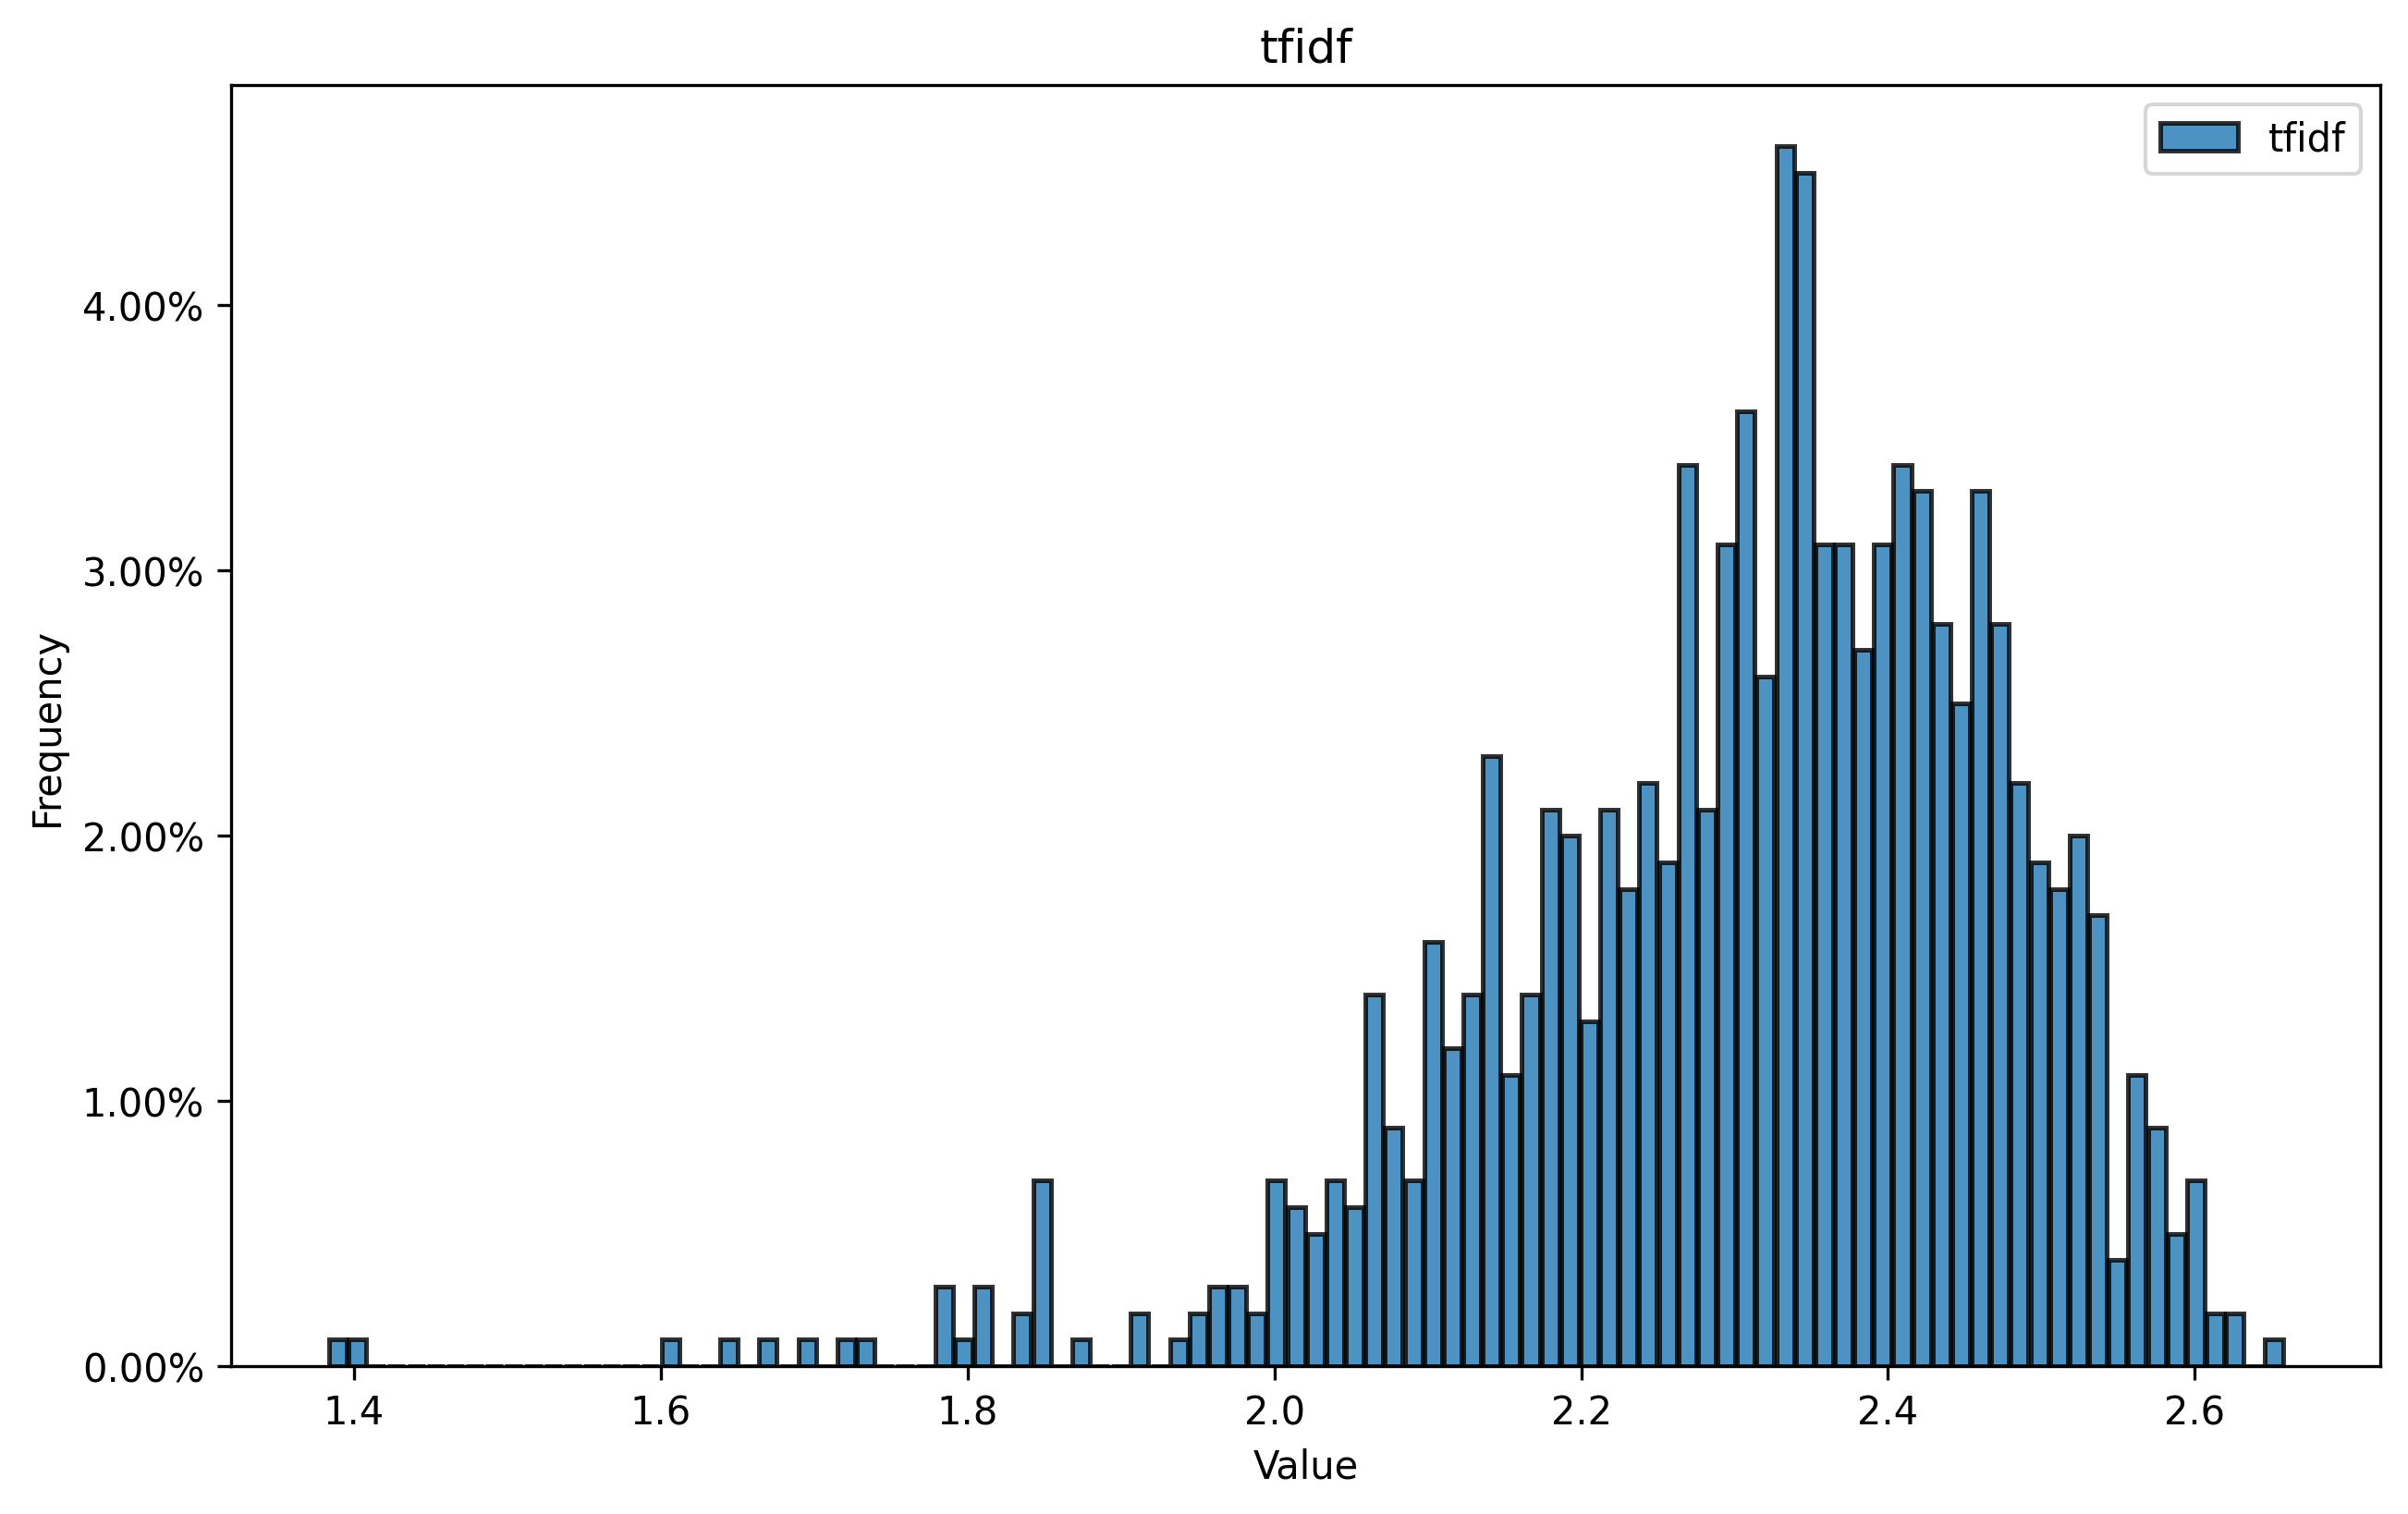

In [27]:
create_histogram_from_raw(
    analyzed_population.raw, keys=["tfidf"], bins=100
)

-----

##### Manual trial-and-error

import gecko

In [28]:
gecko = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3B)])]")

mutate brick -> hinge close to root

In [29]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HHHB[l(H1B)r(H3B)])]")

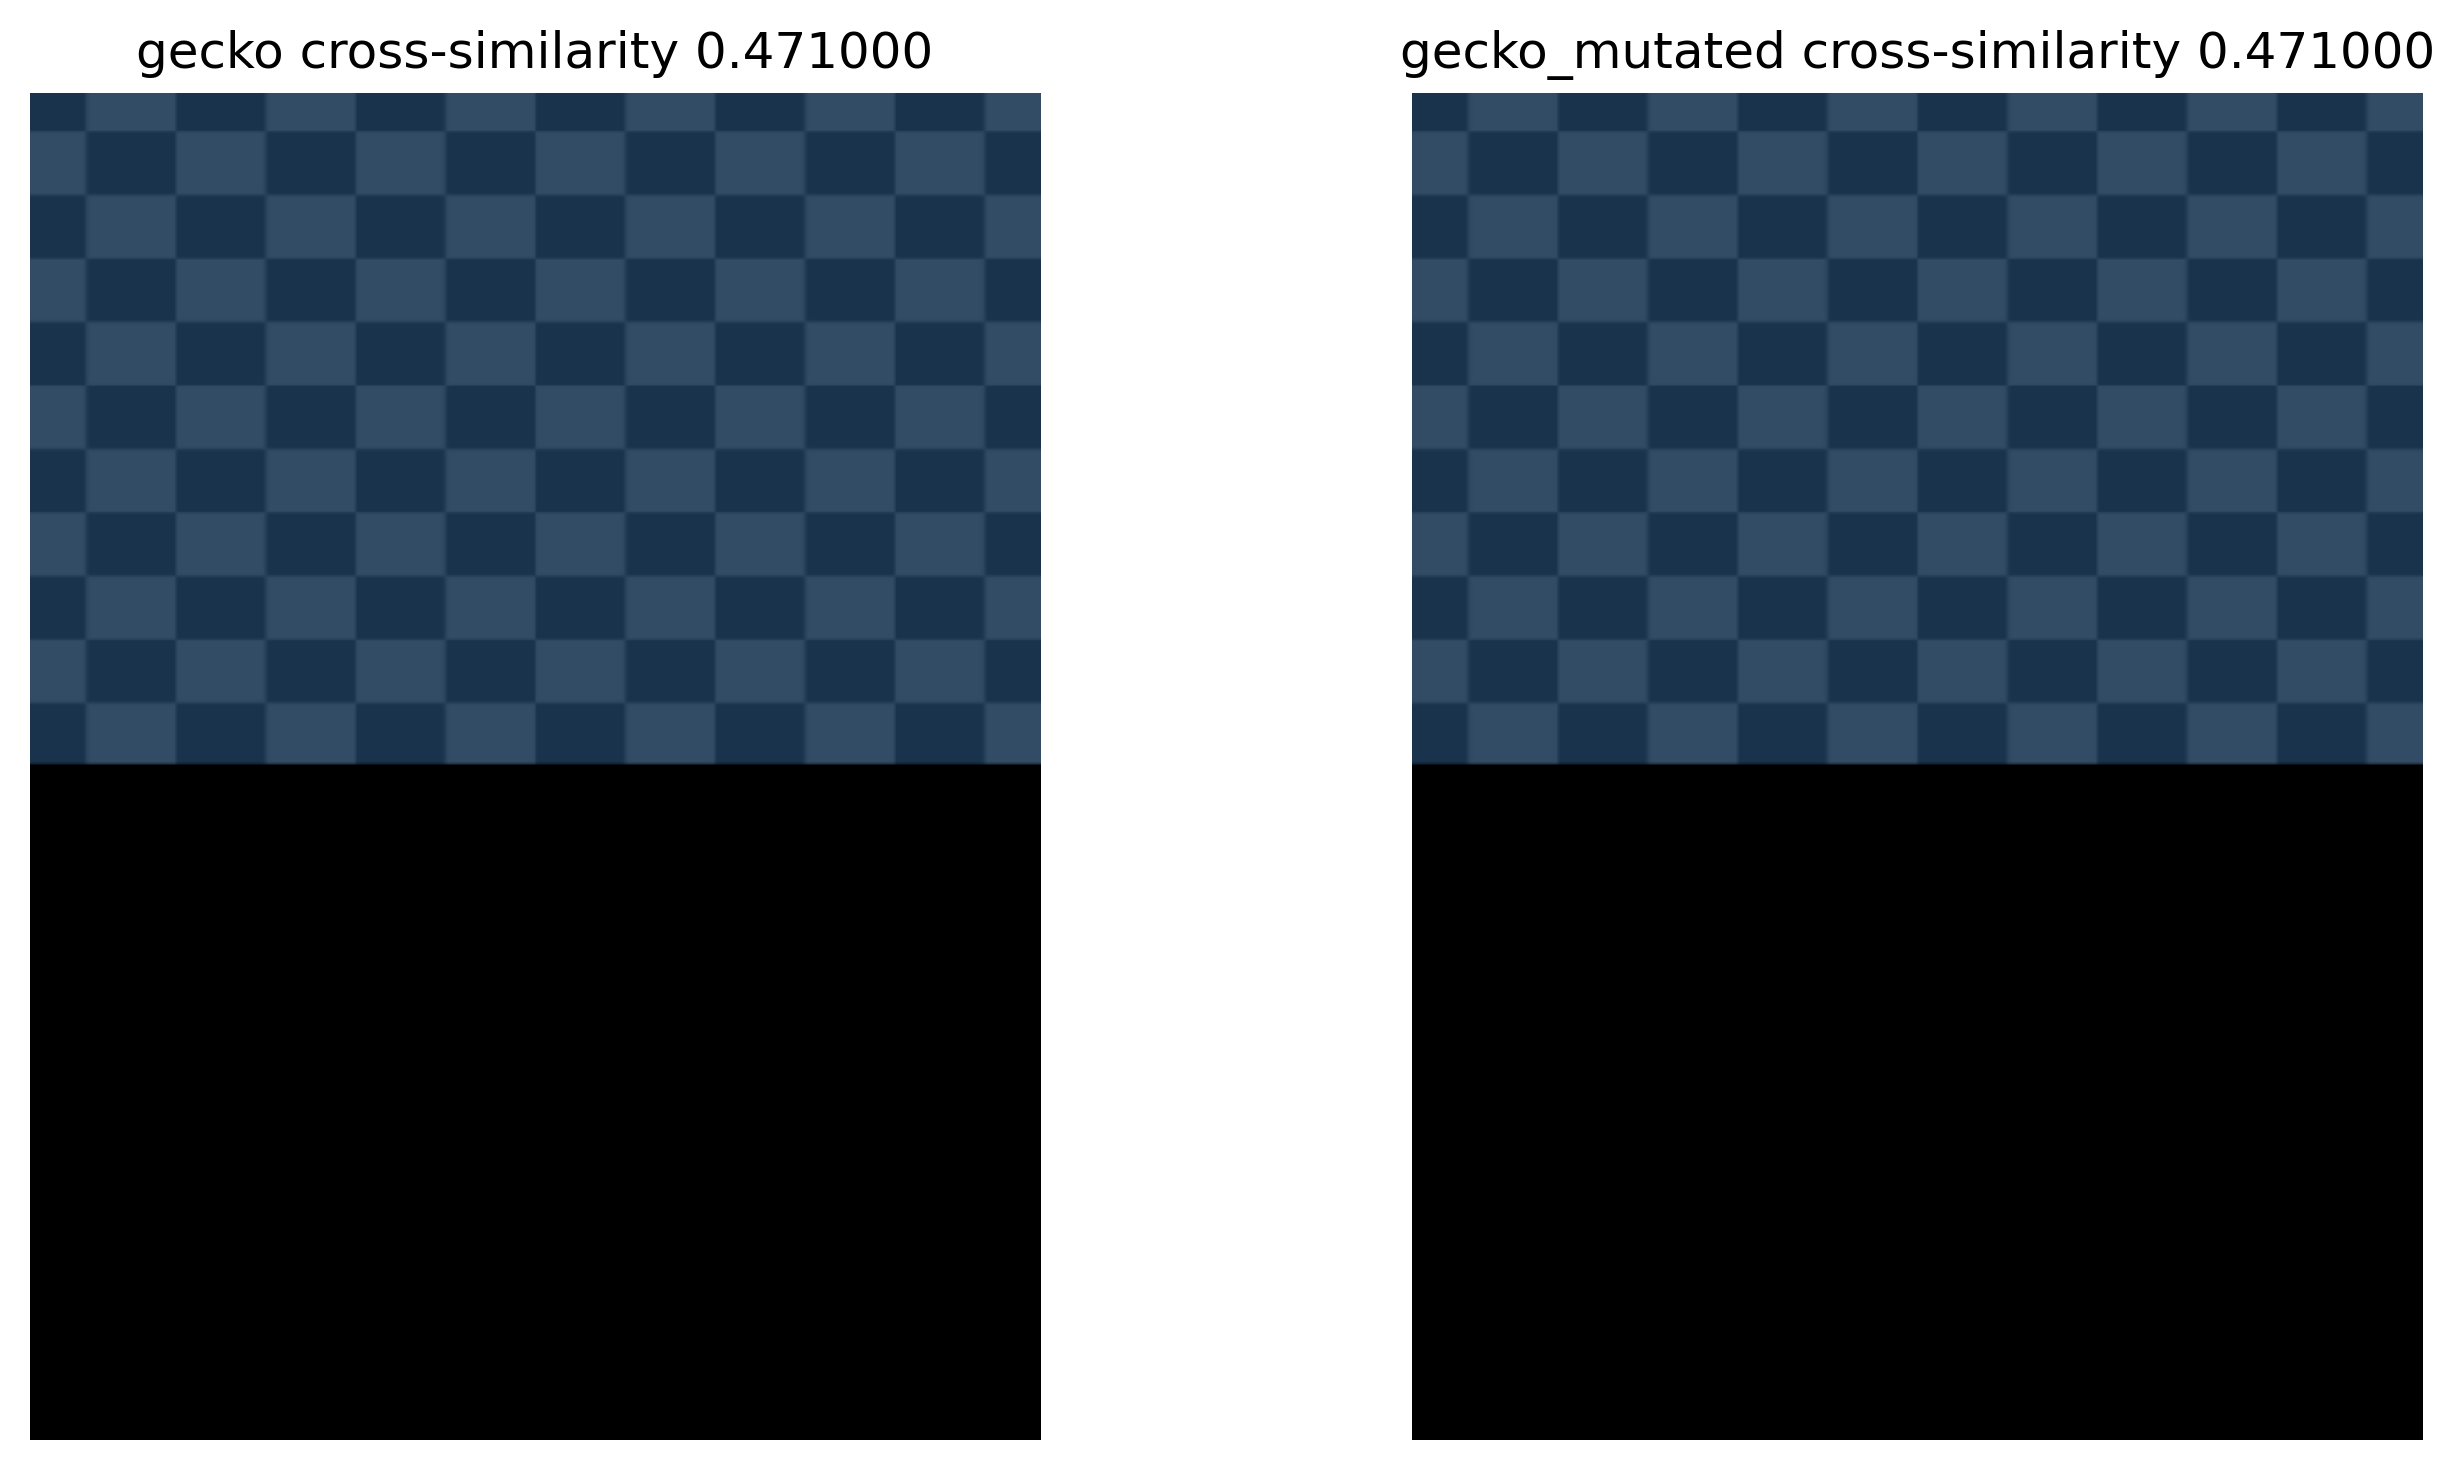

In [30]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

mutate brick -> hinge close to leaf

In [31]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(B3B)])]")

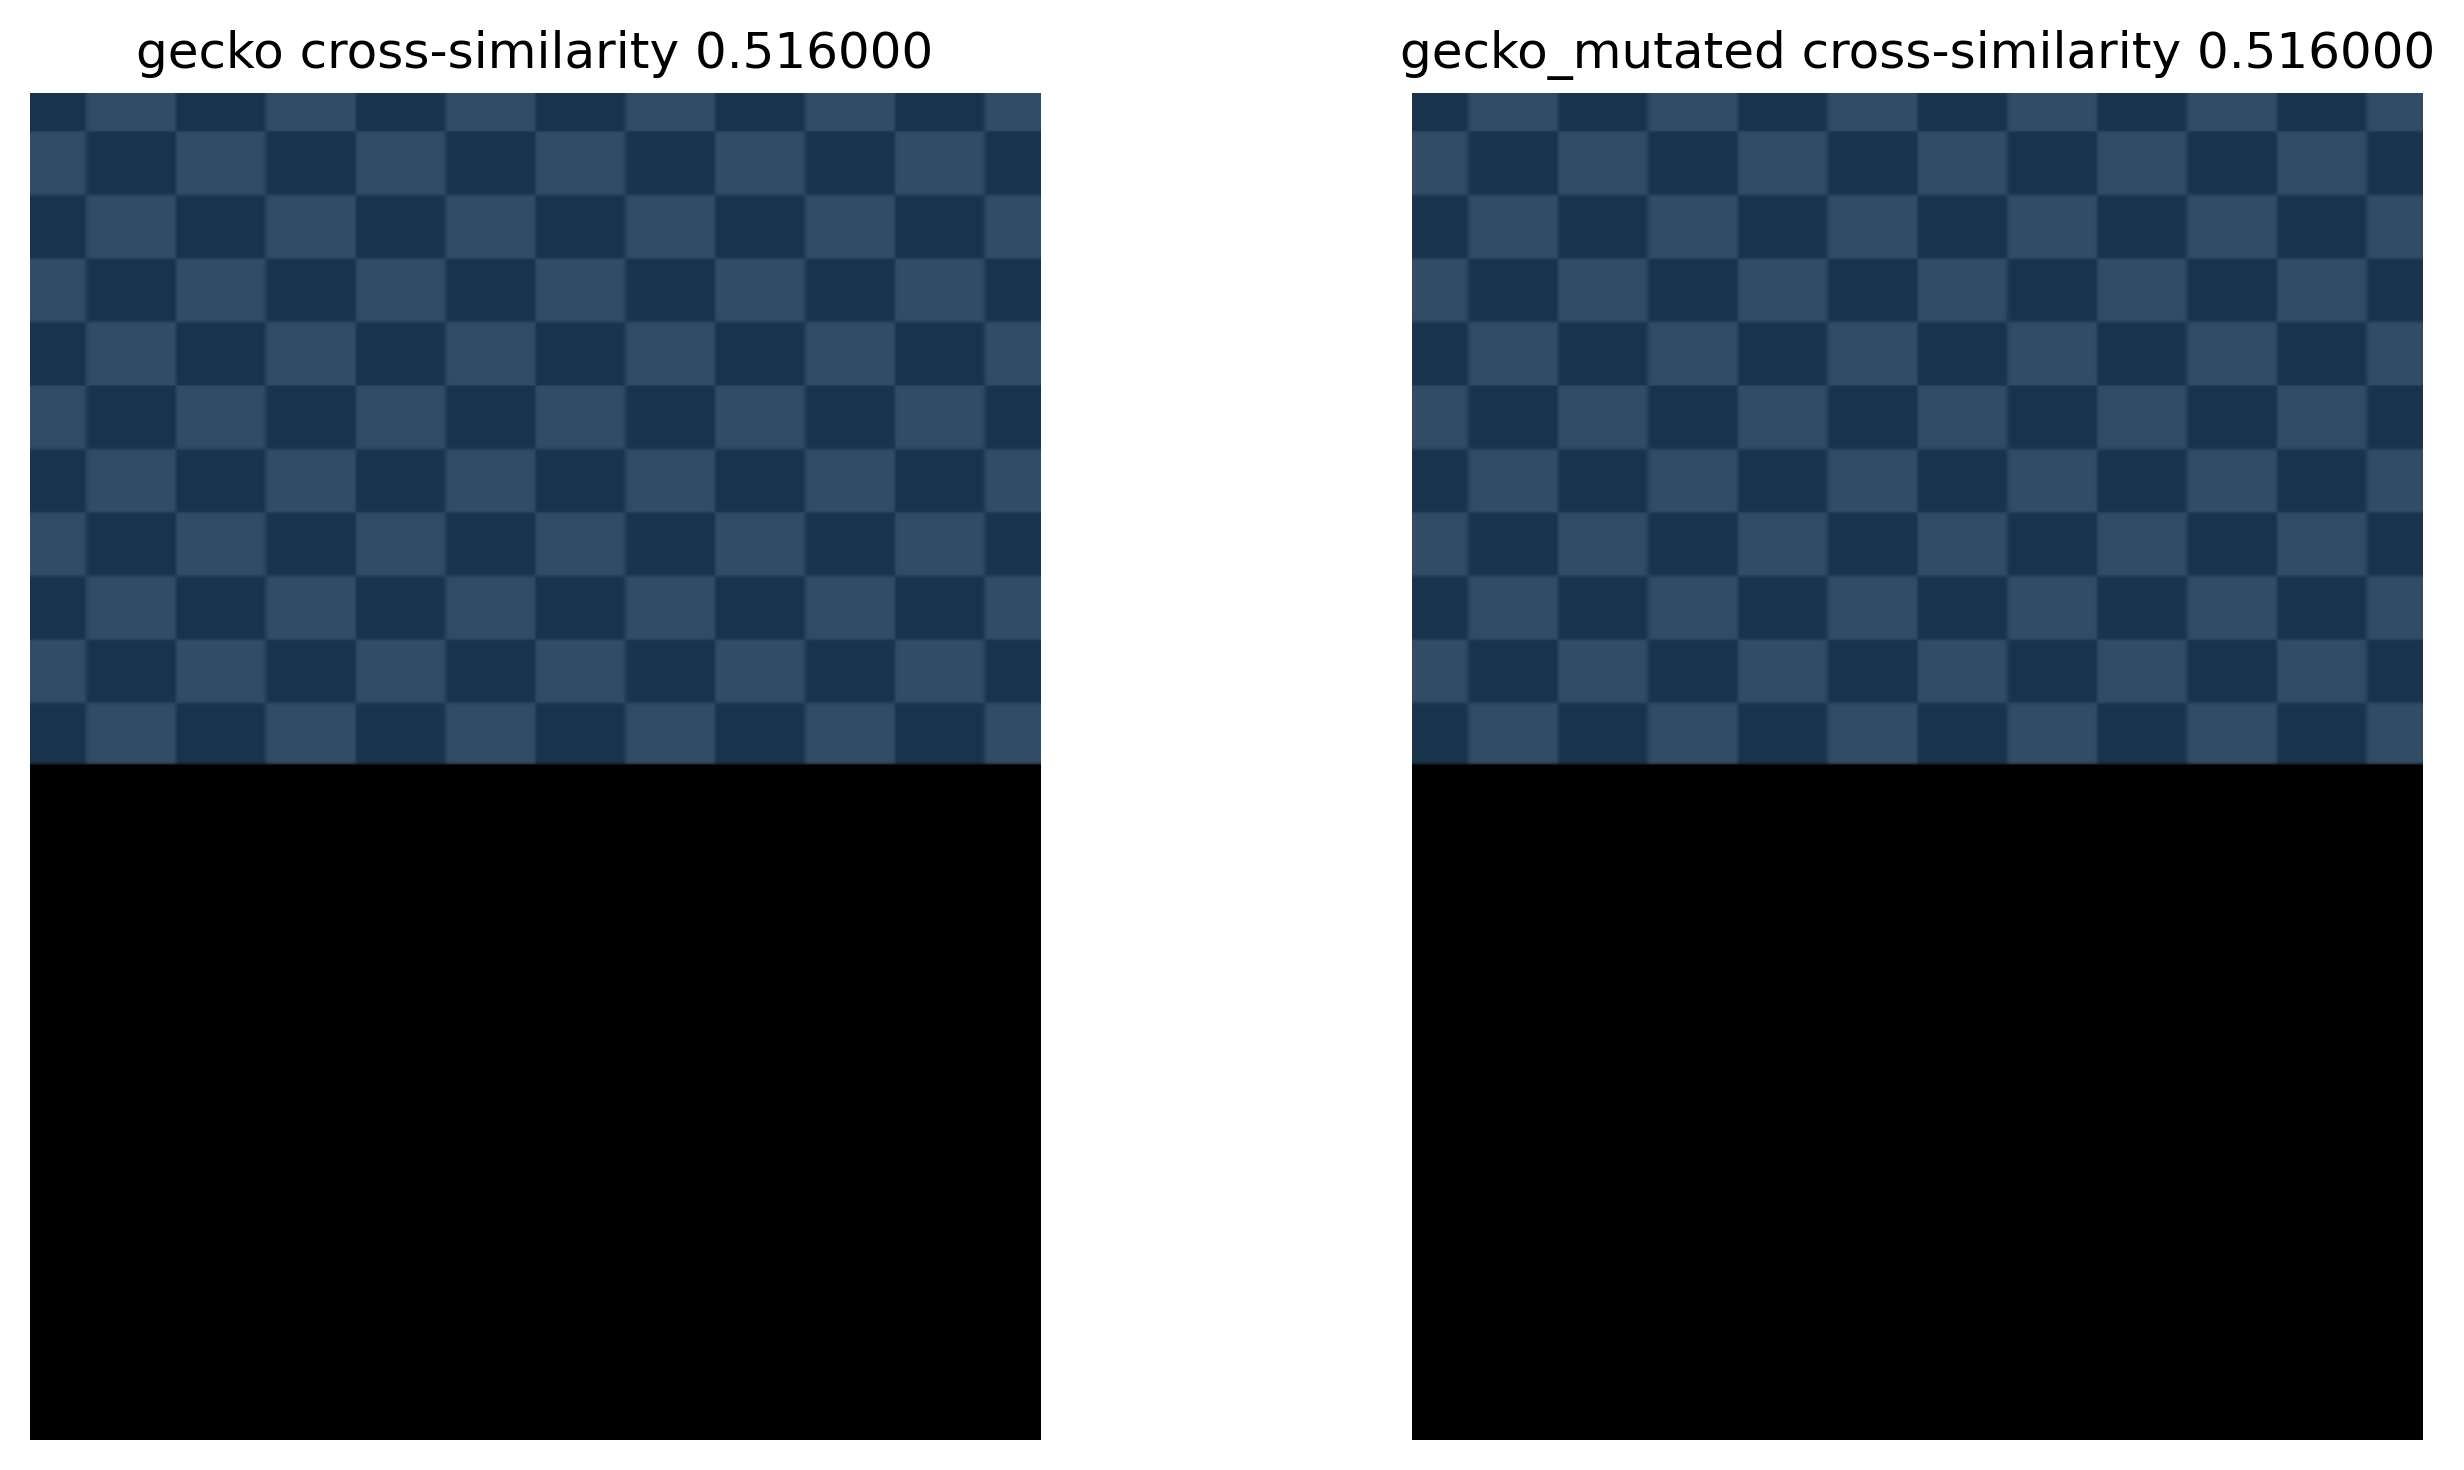

In [32]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

change rotation close to root

In [33]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(H4BHB[l(H1B)r(H3B)])]")

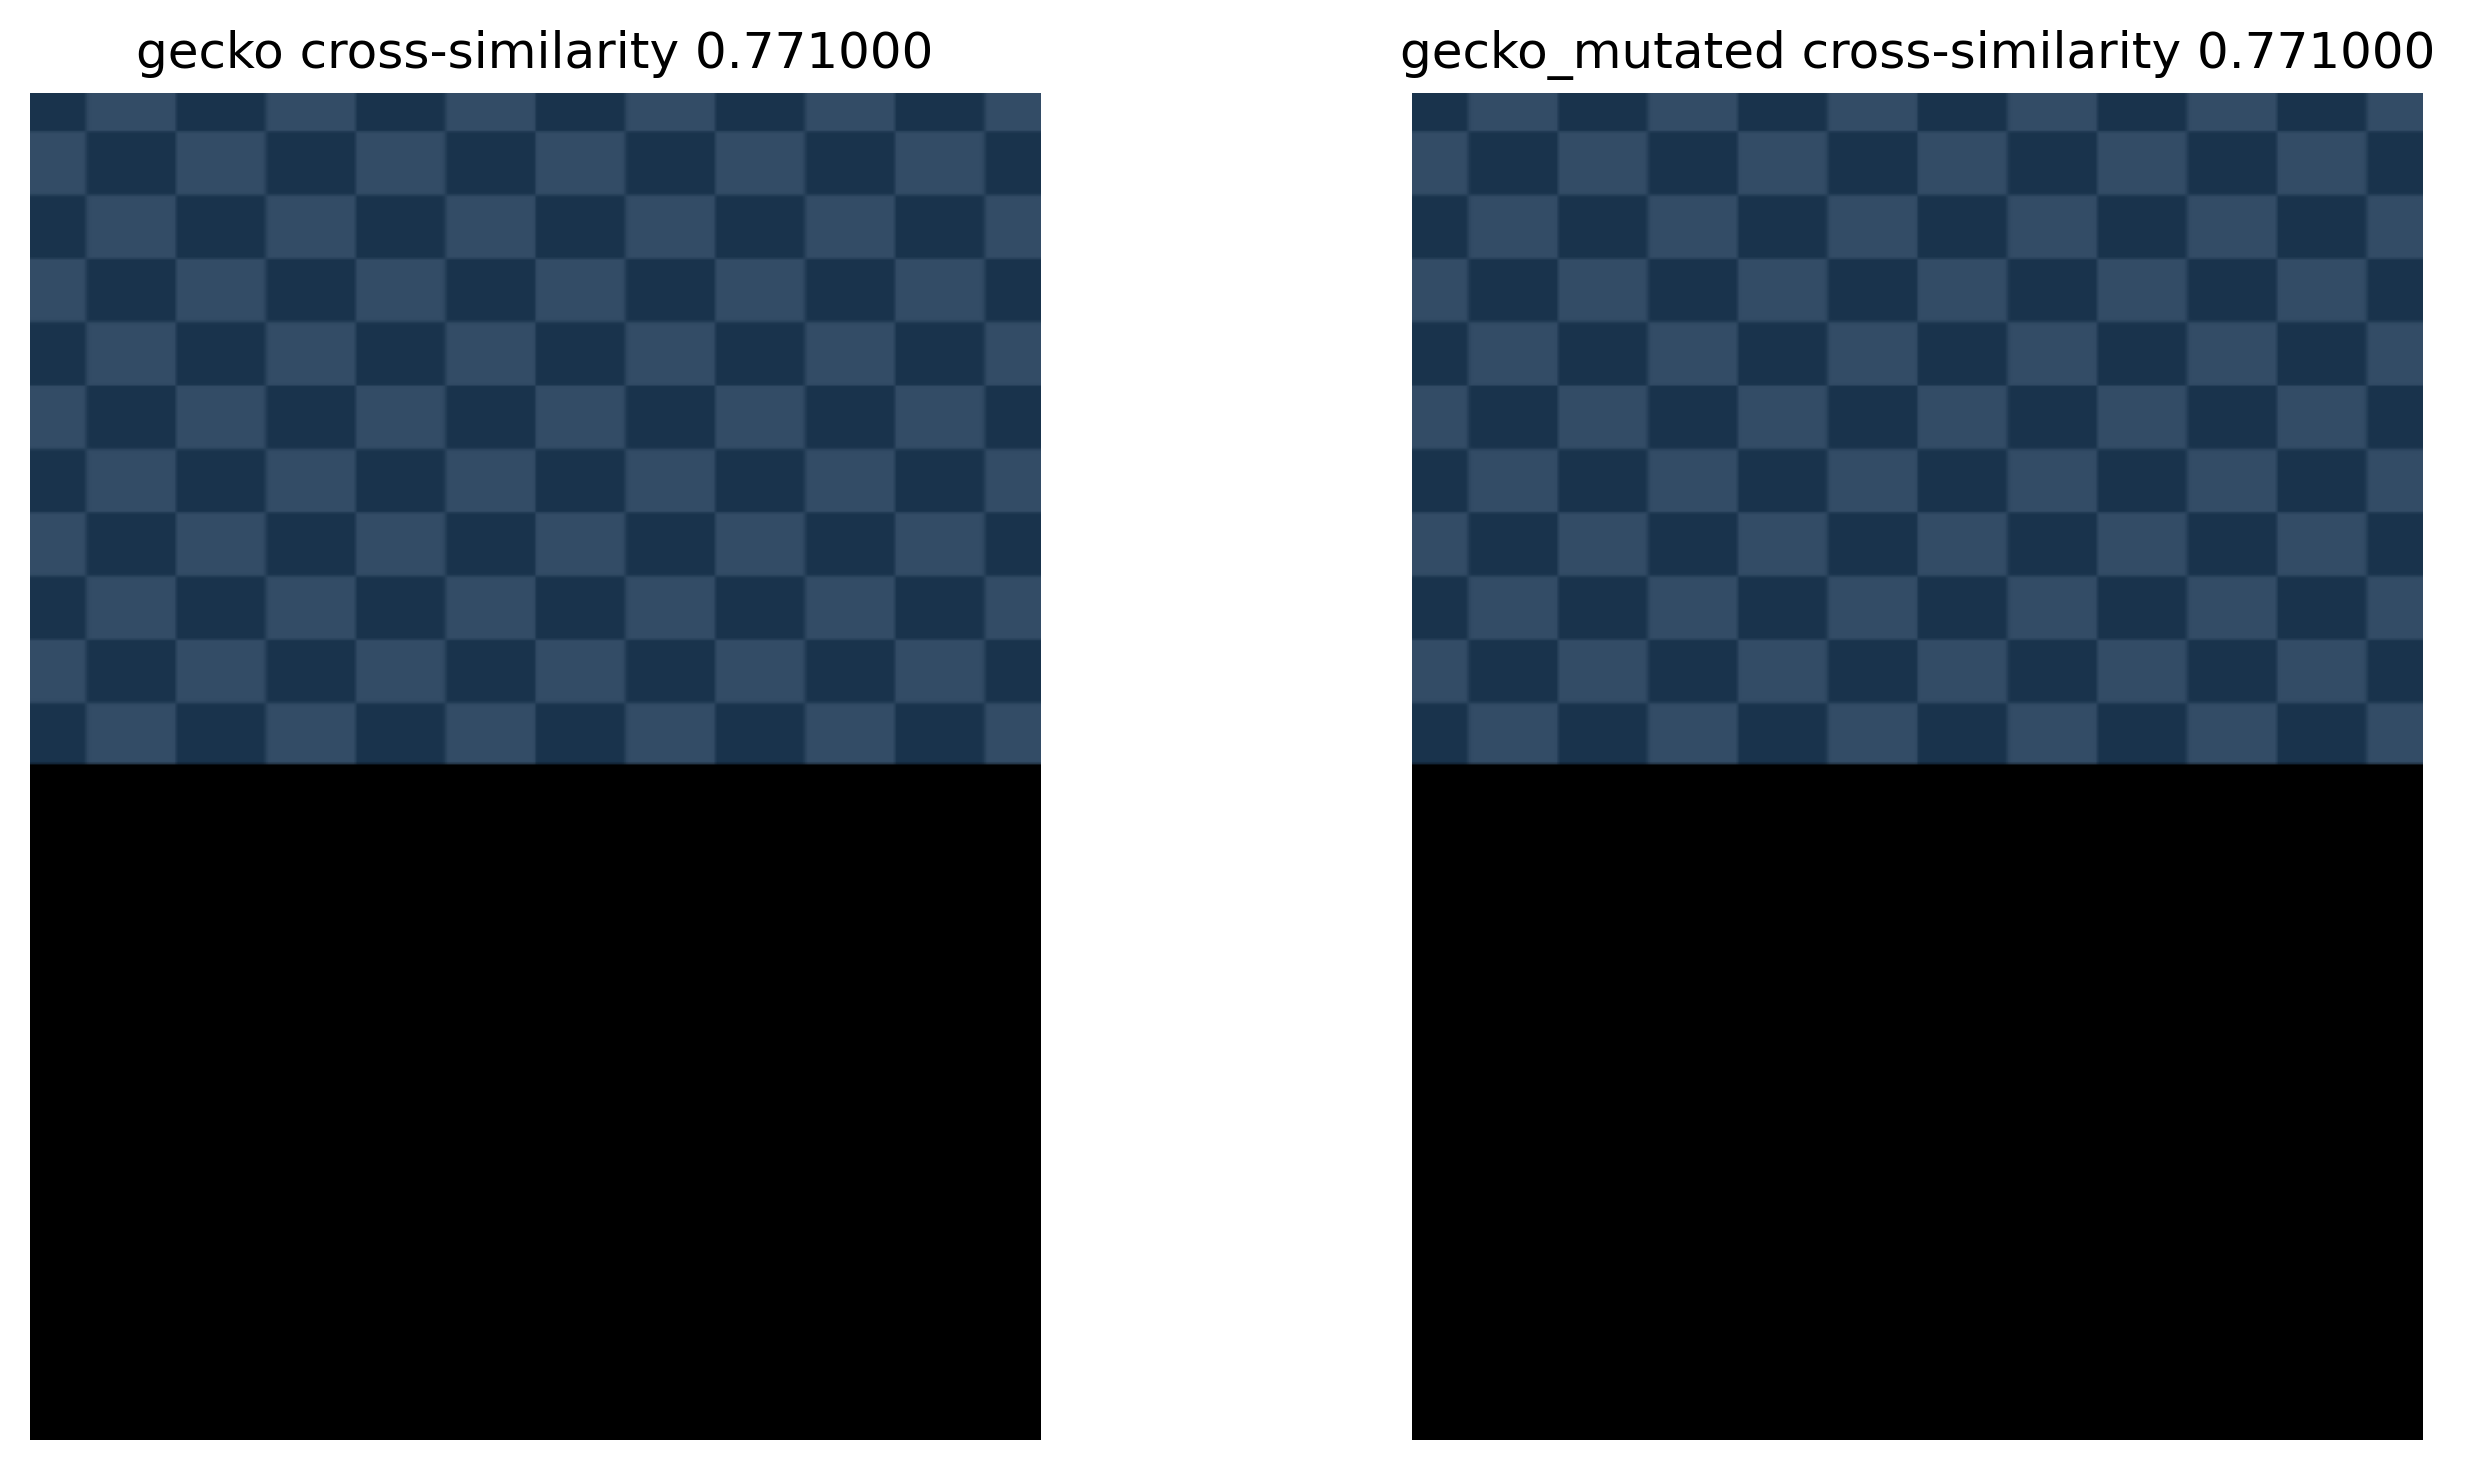

In [34]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

change rotation close to leaf

In [35]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3B1)])]")

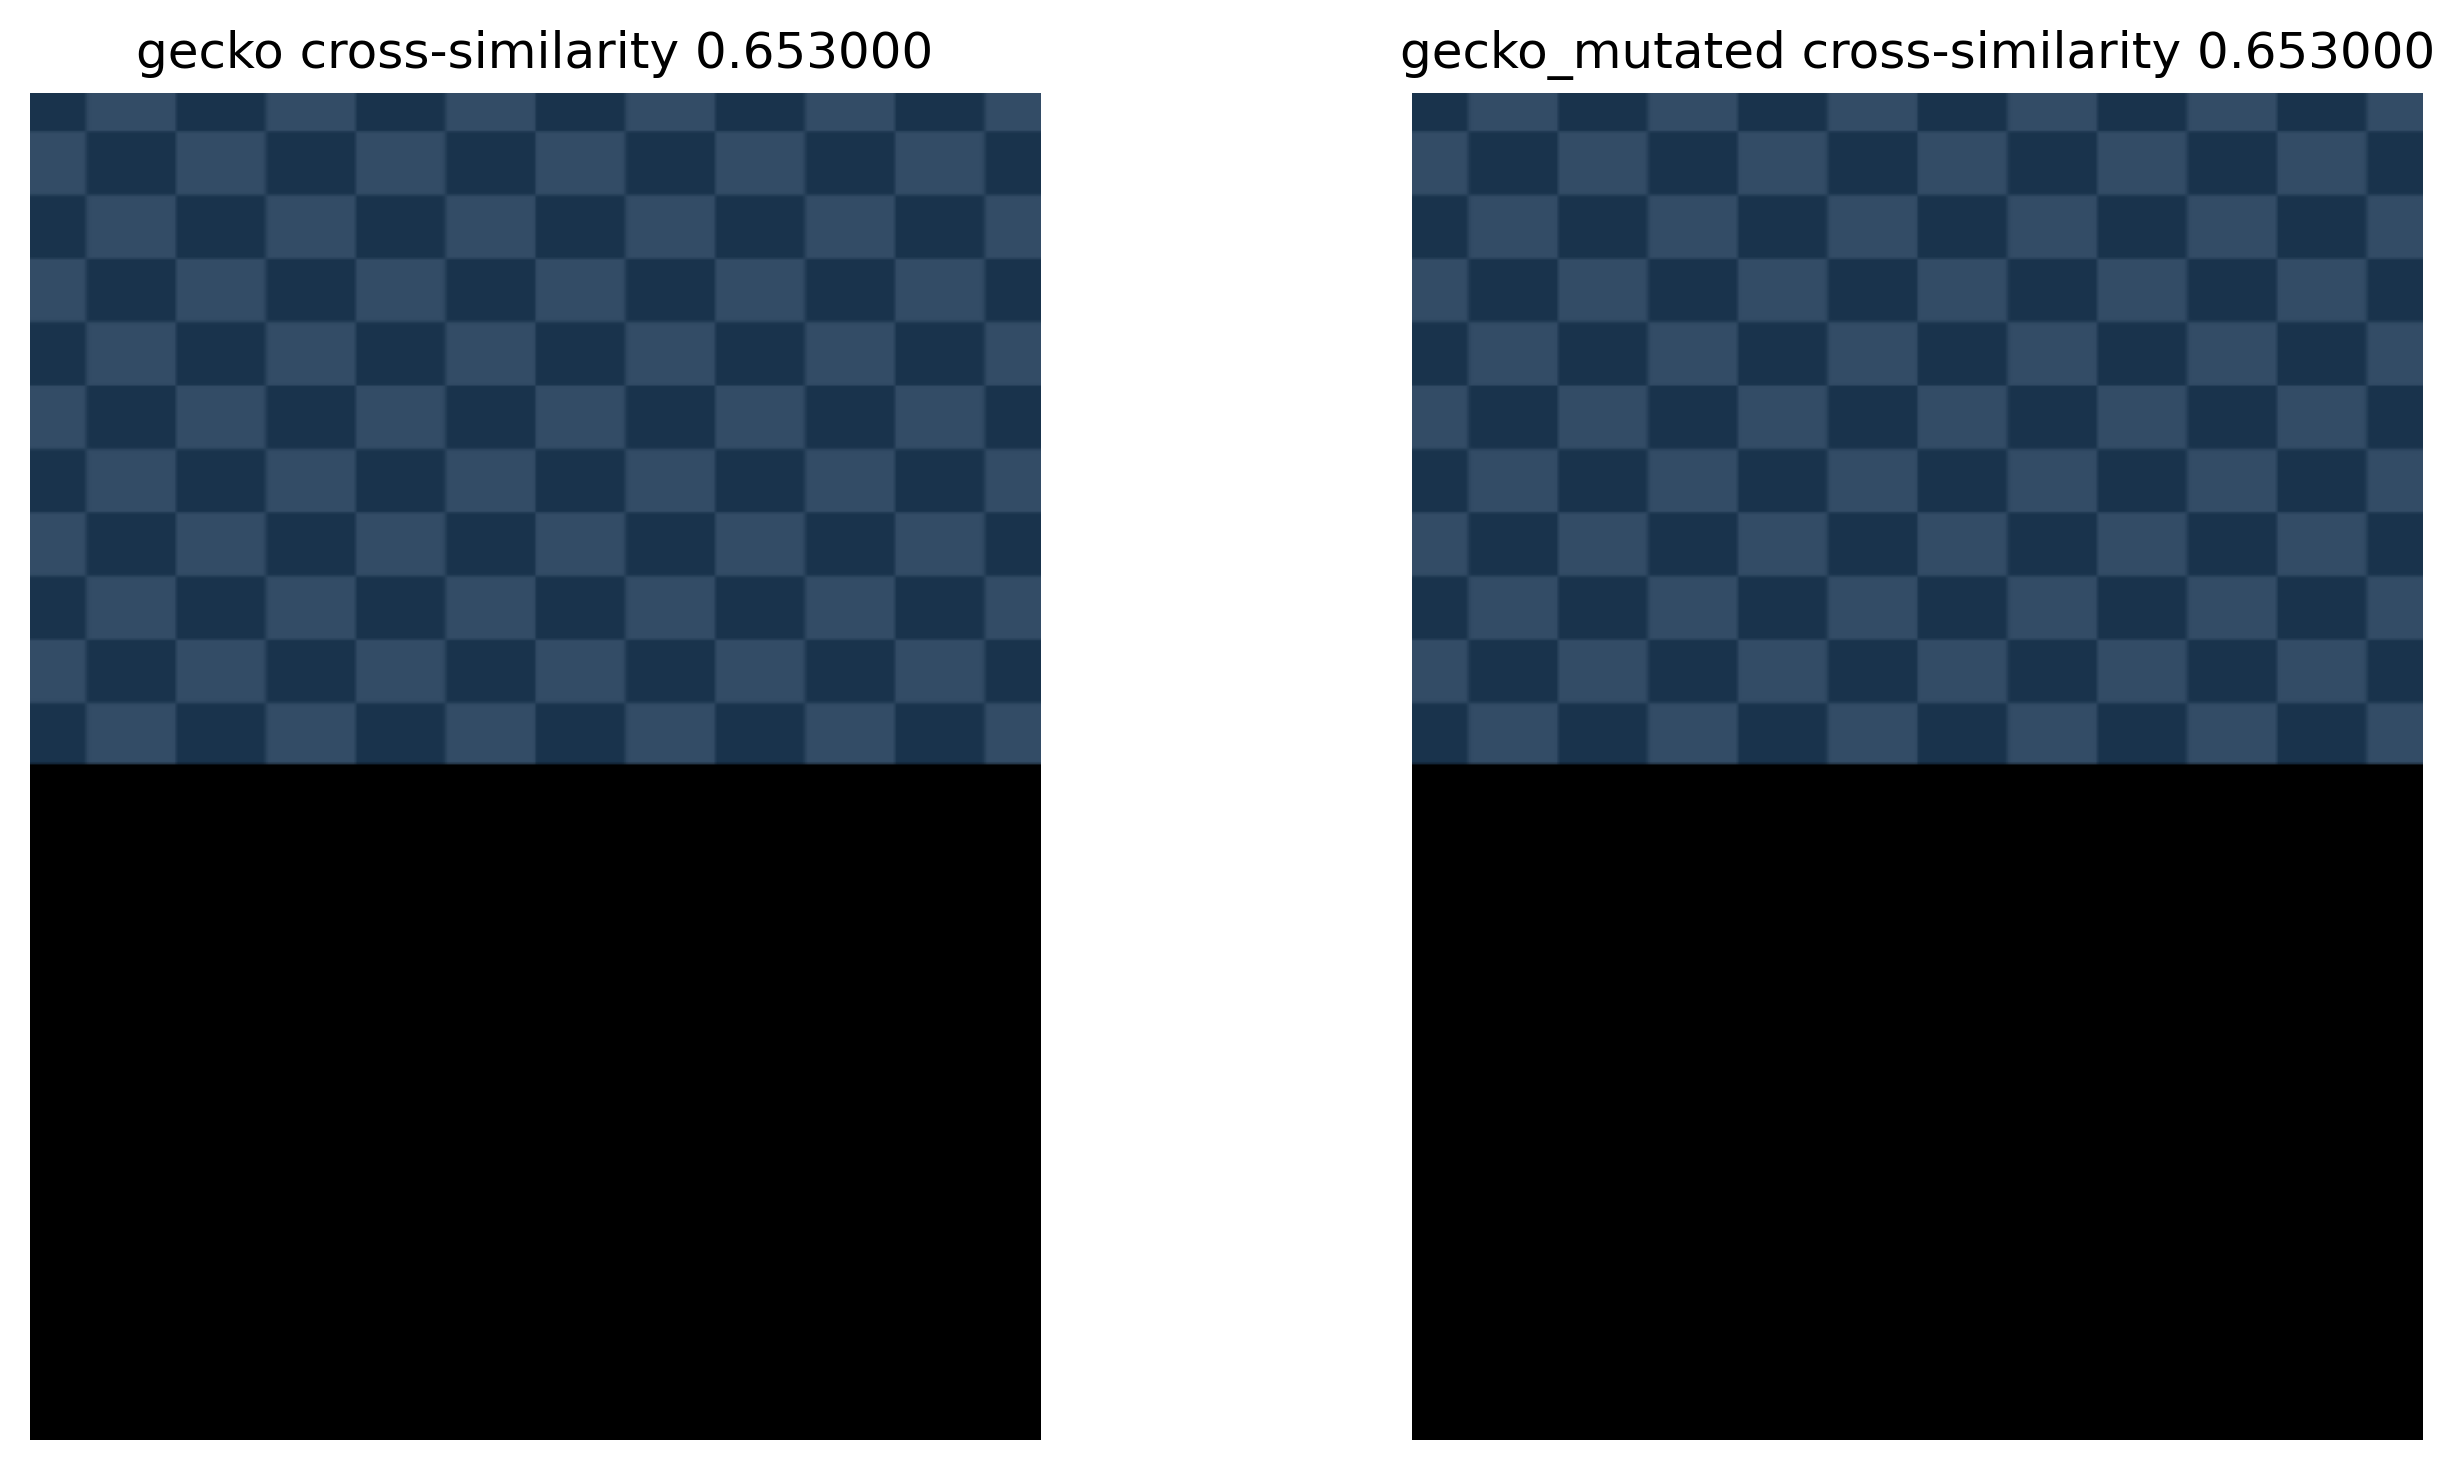

In [36]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

addition

In [37]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3BB)])]")

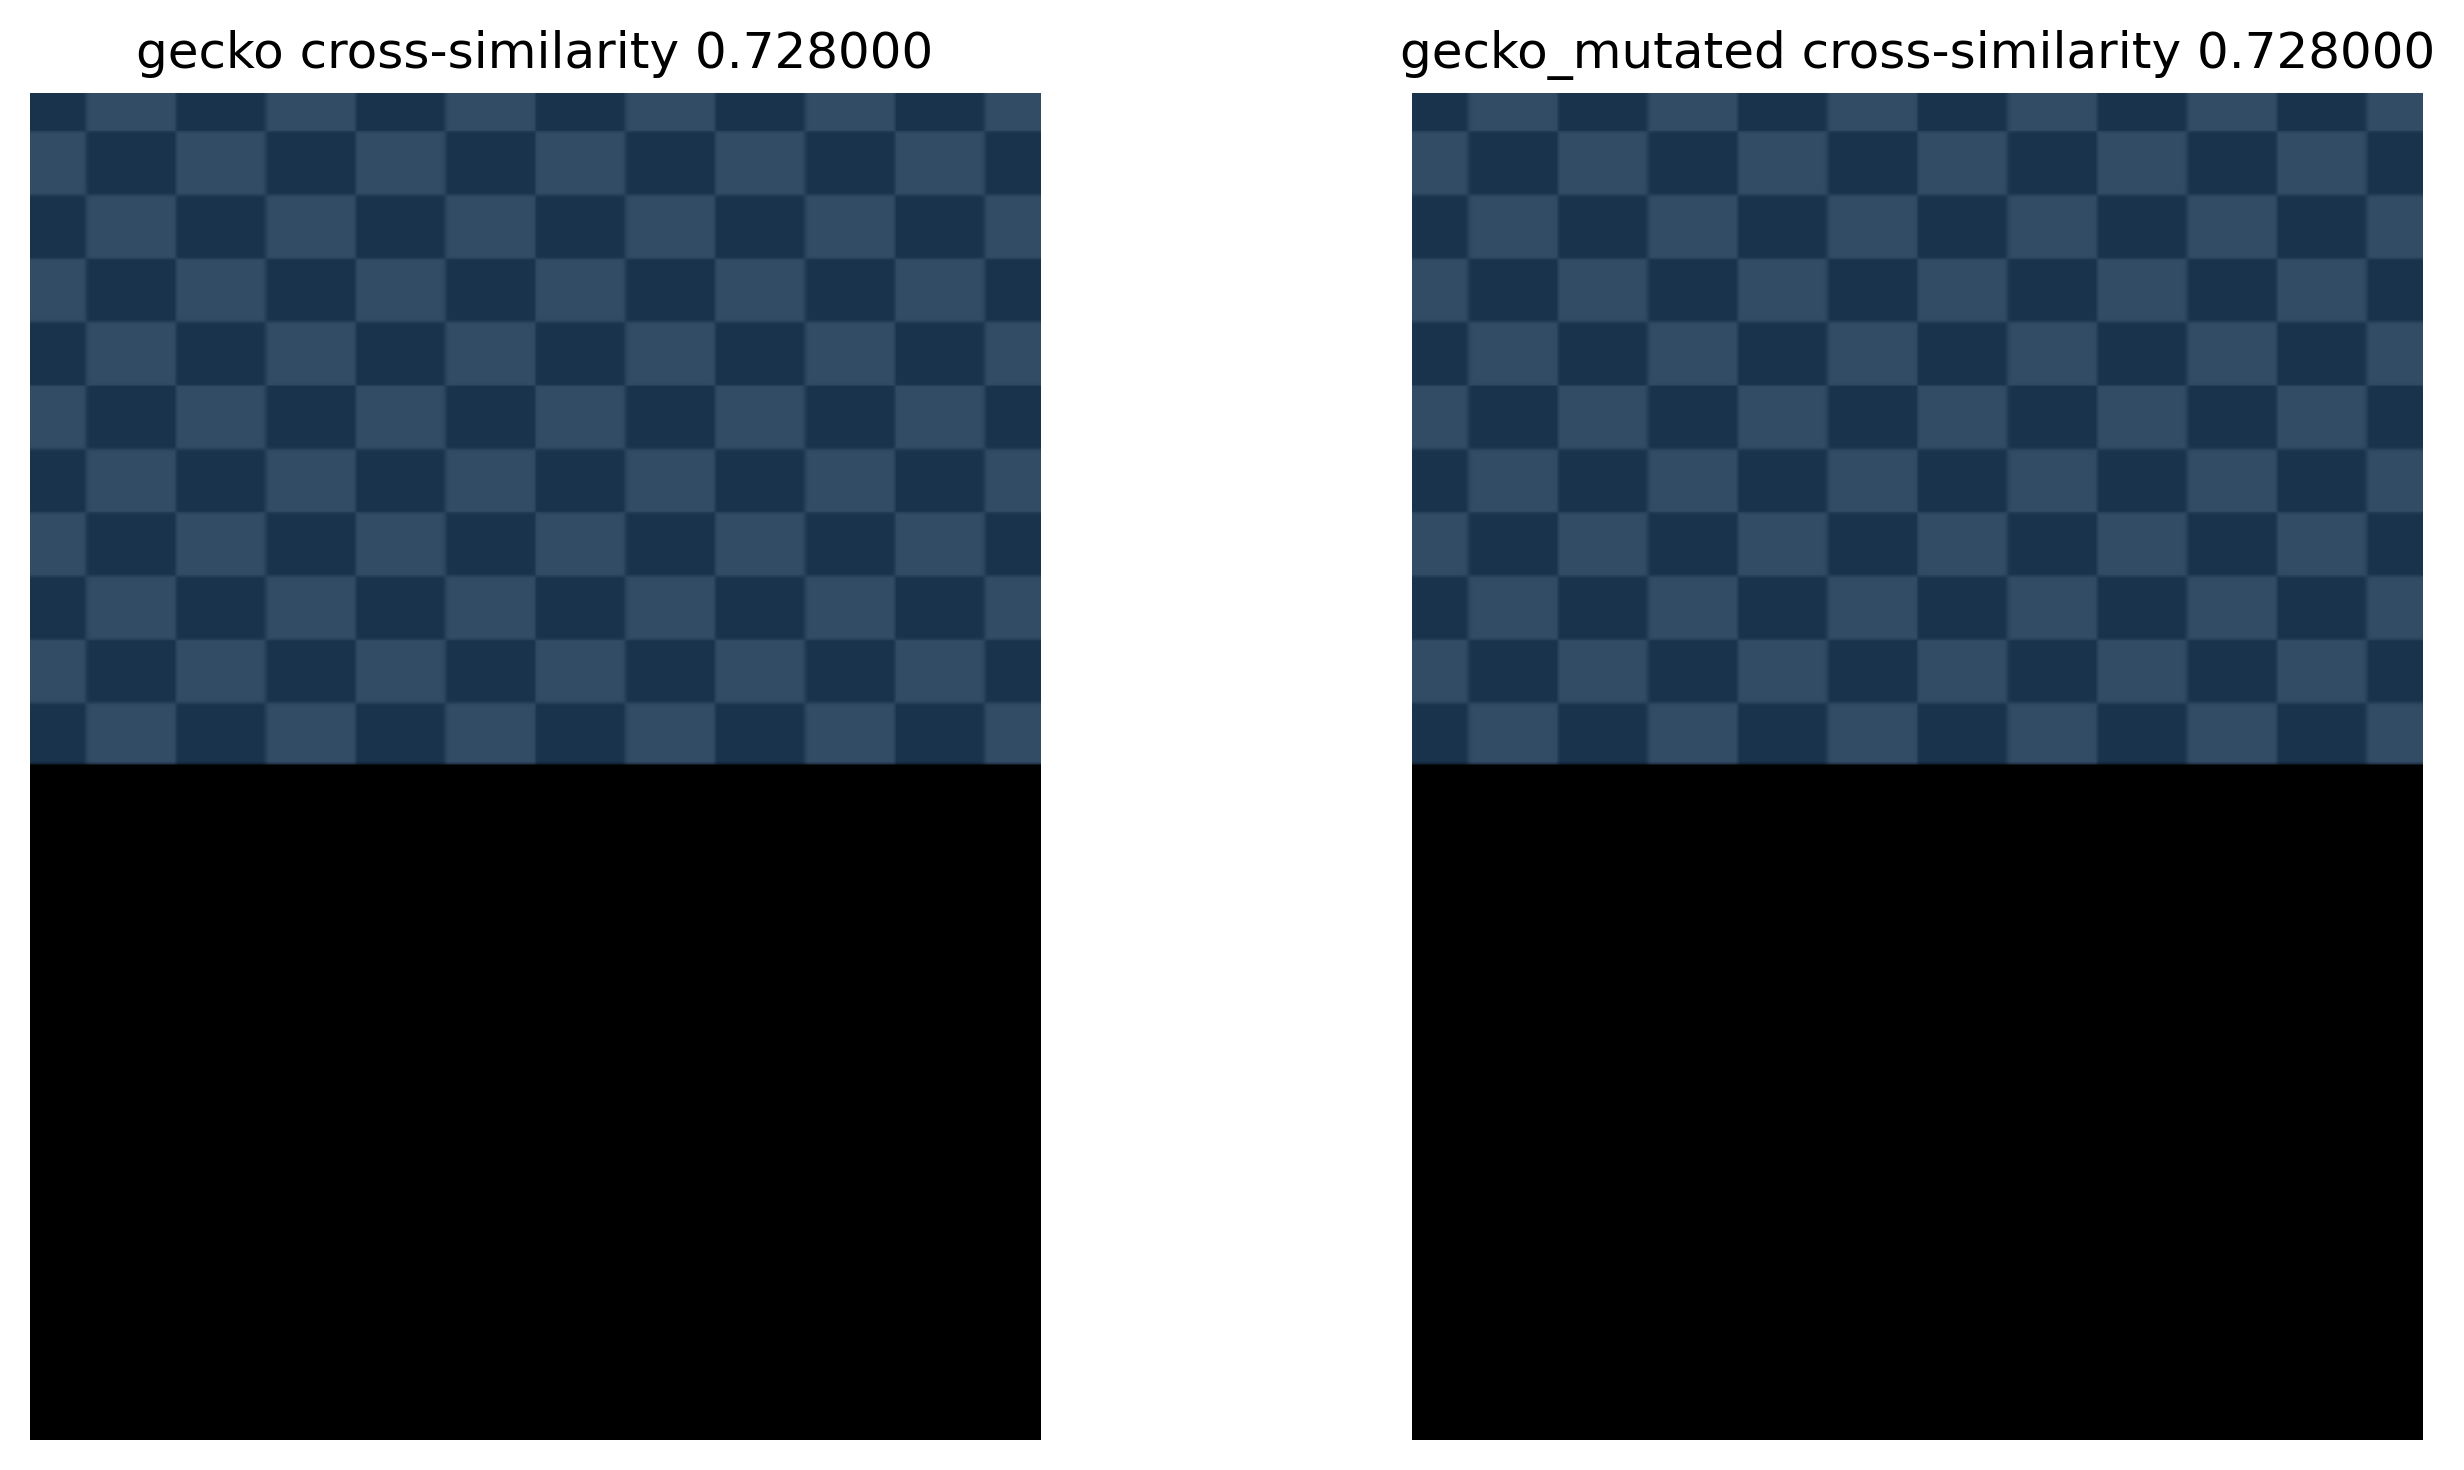

In [38]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

In [39]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HHBHB[l(H1B)r(H3B)])]")

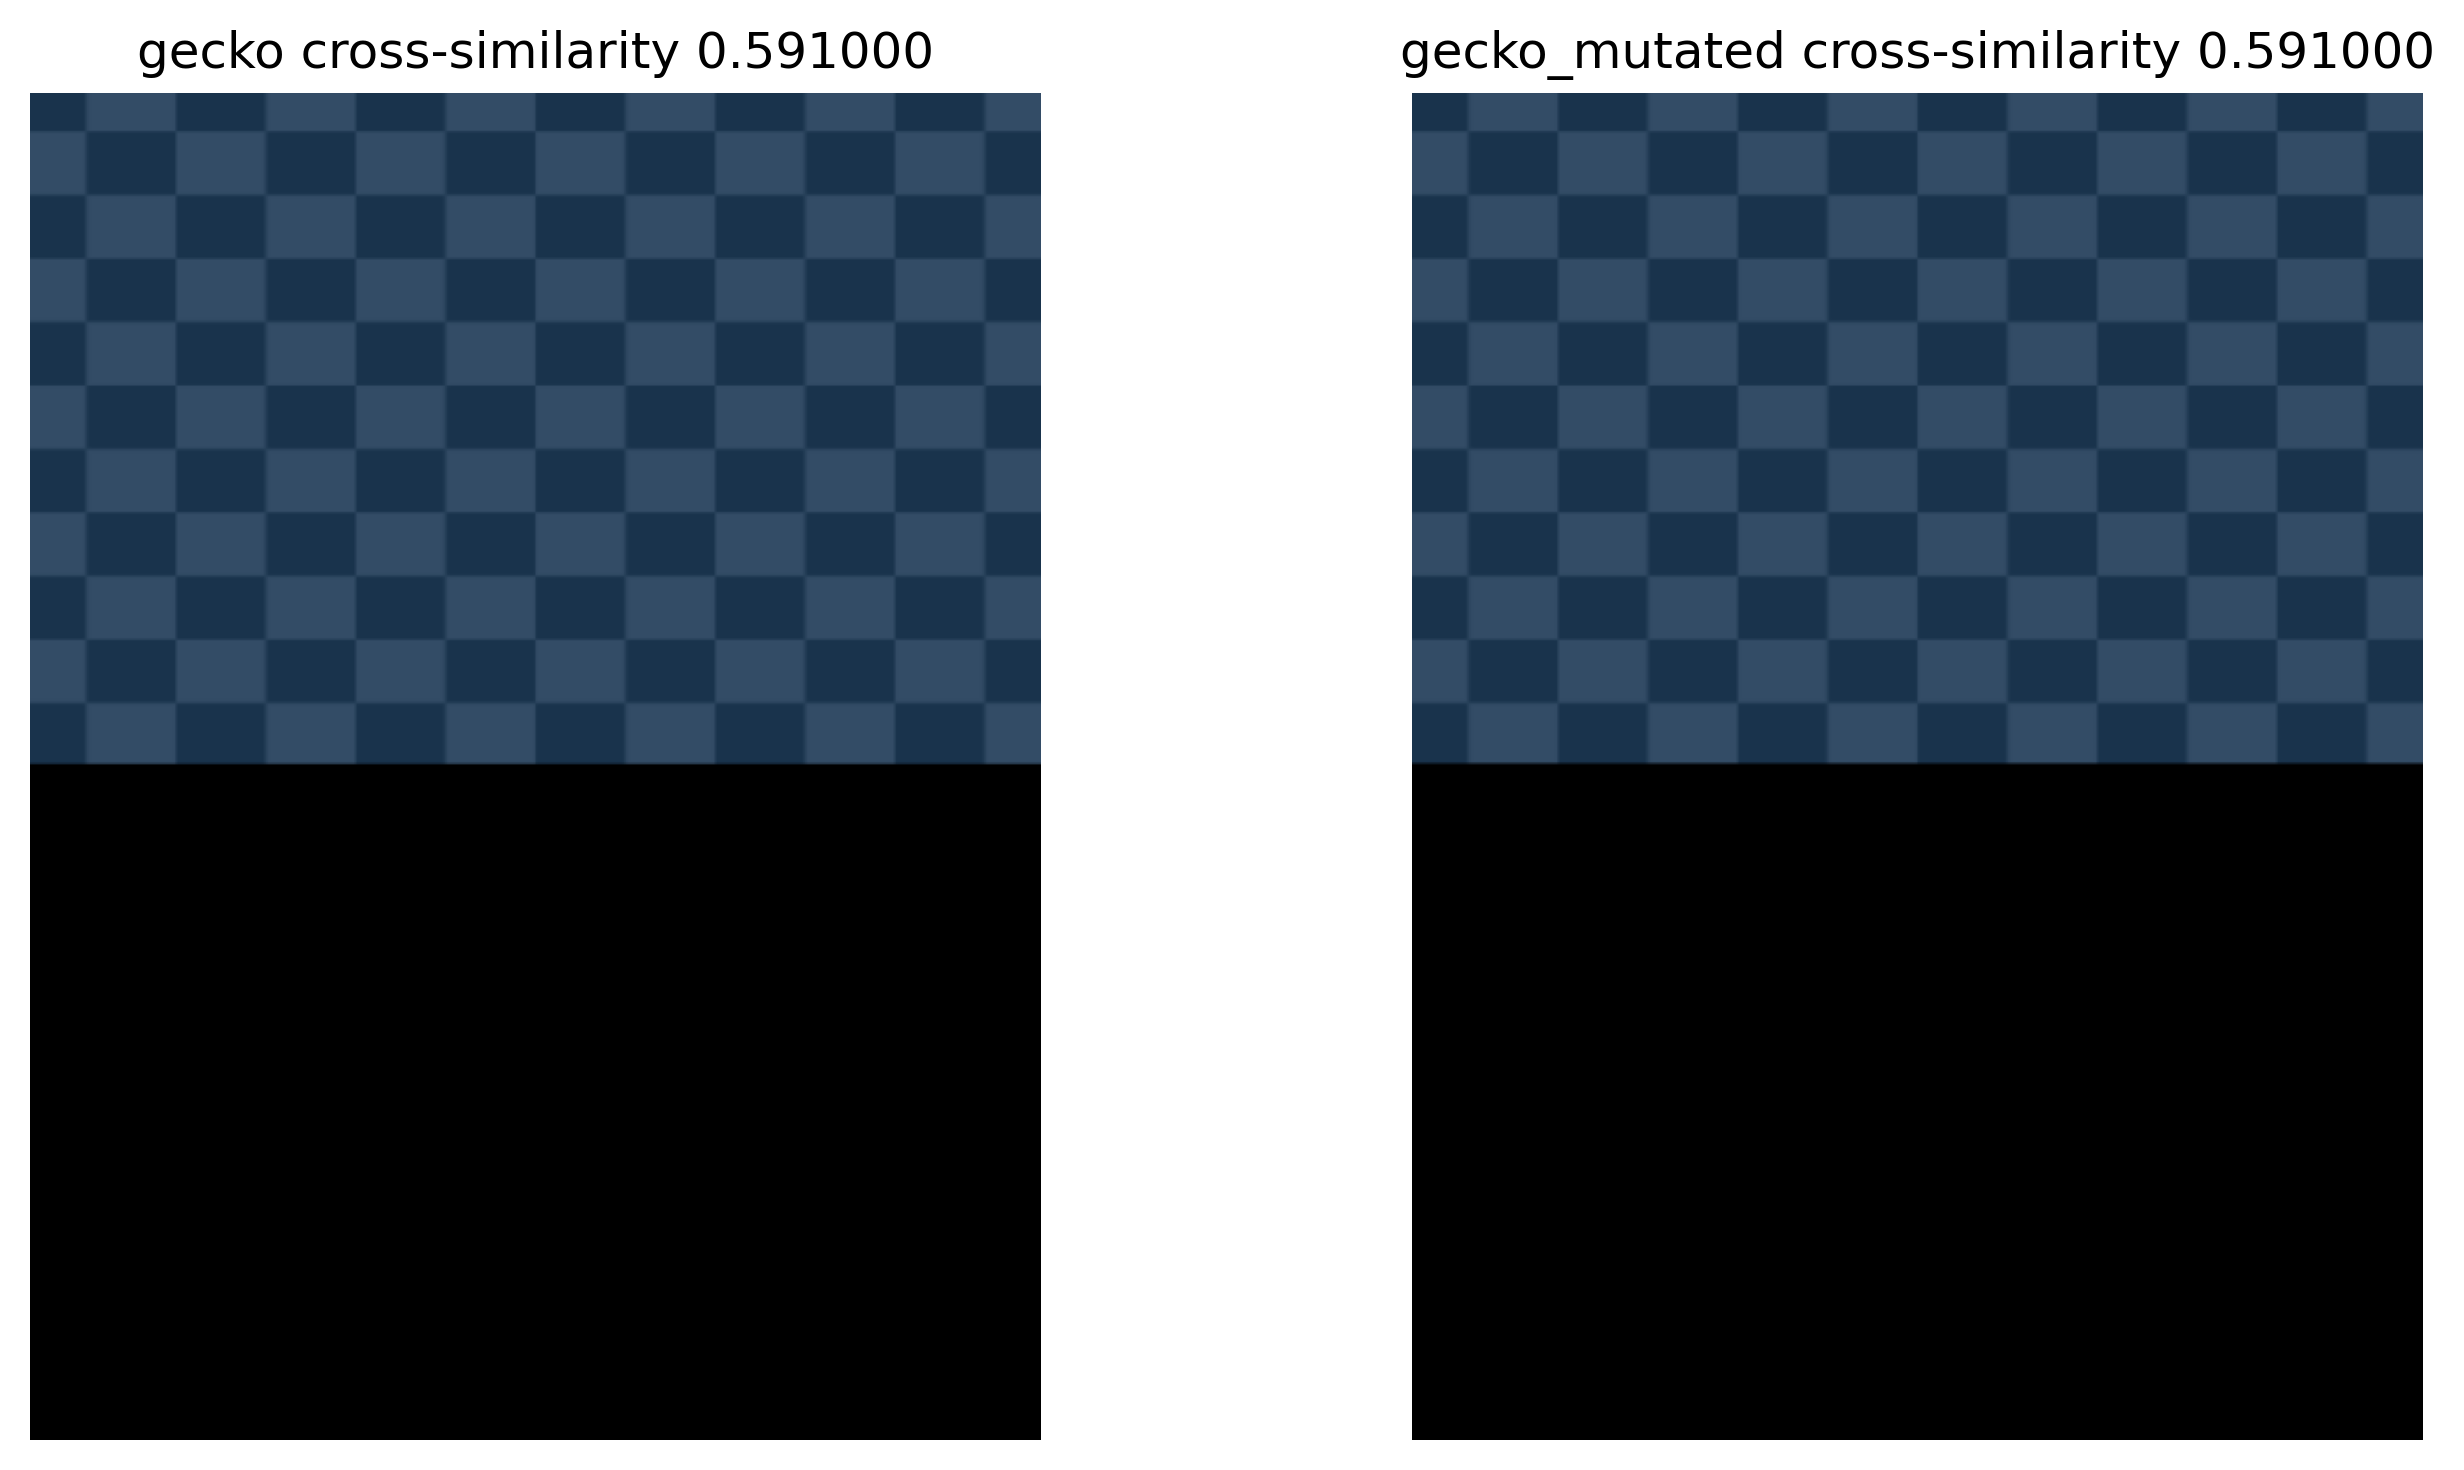

In [40]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

deletion close to root

In [41]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(BHB[l(H1B)r(H3B)])]")

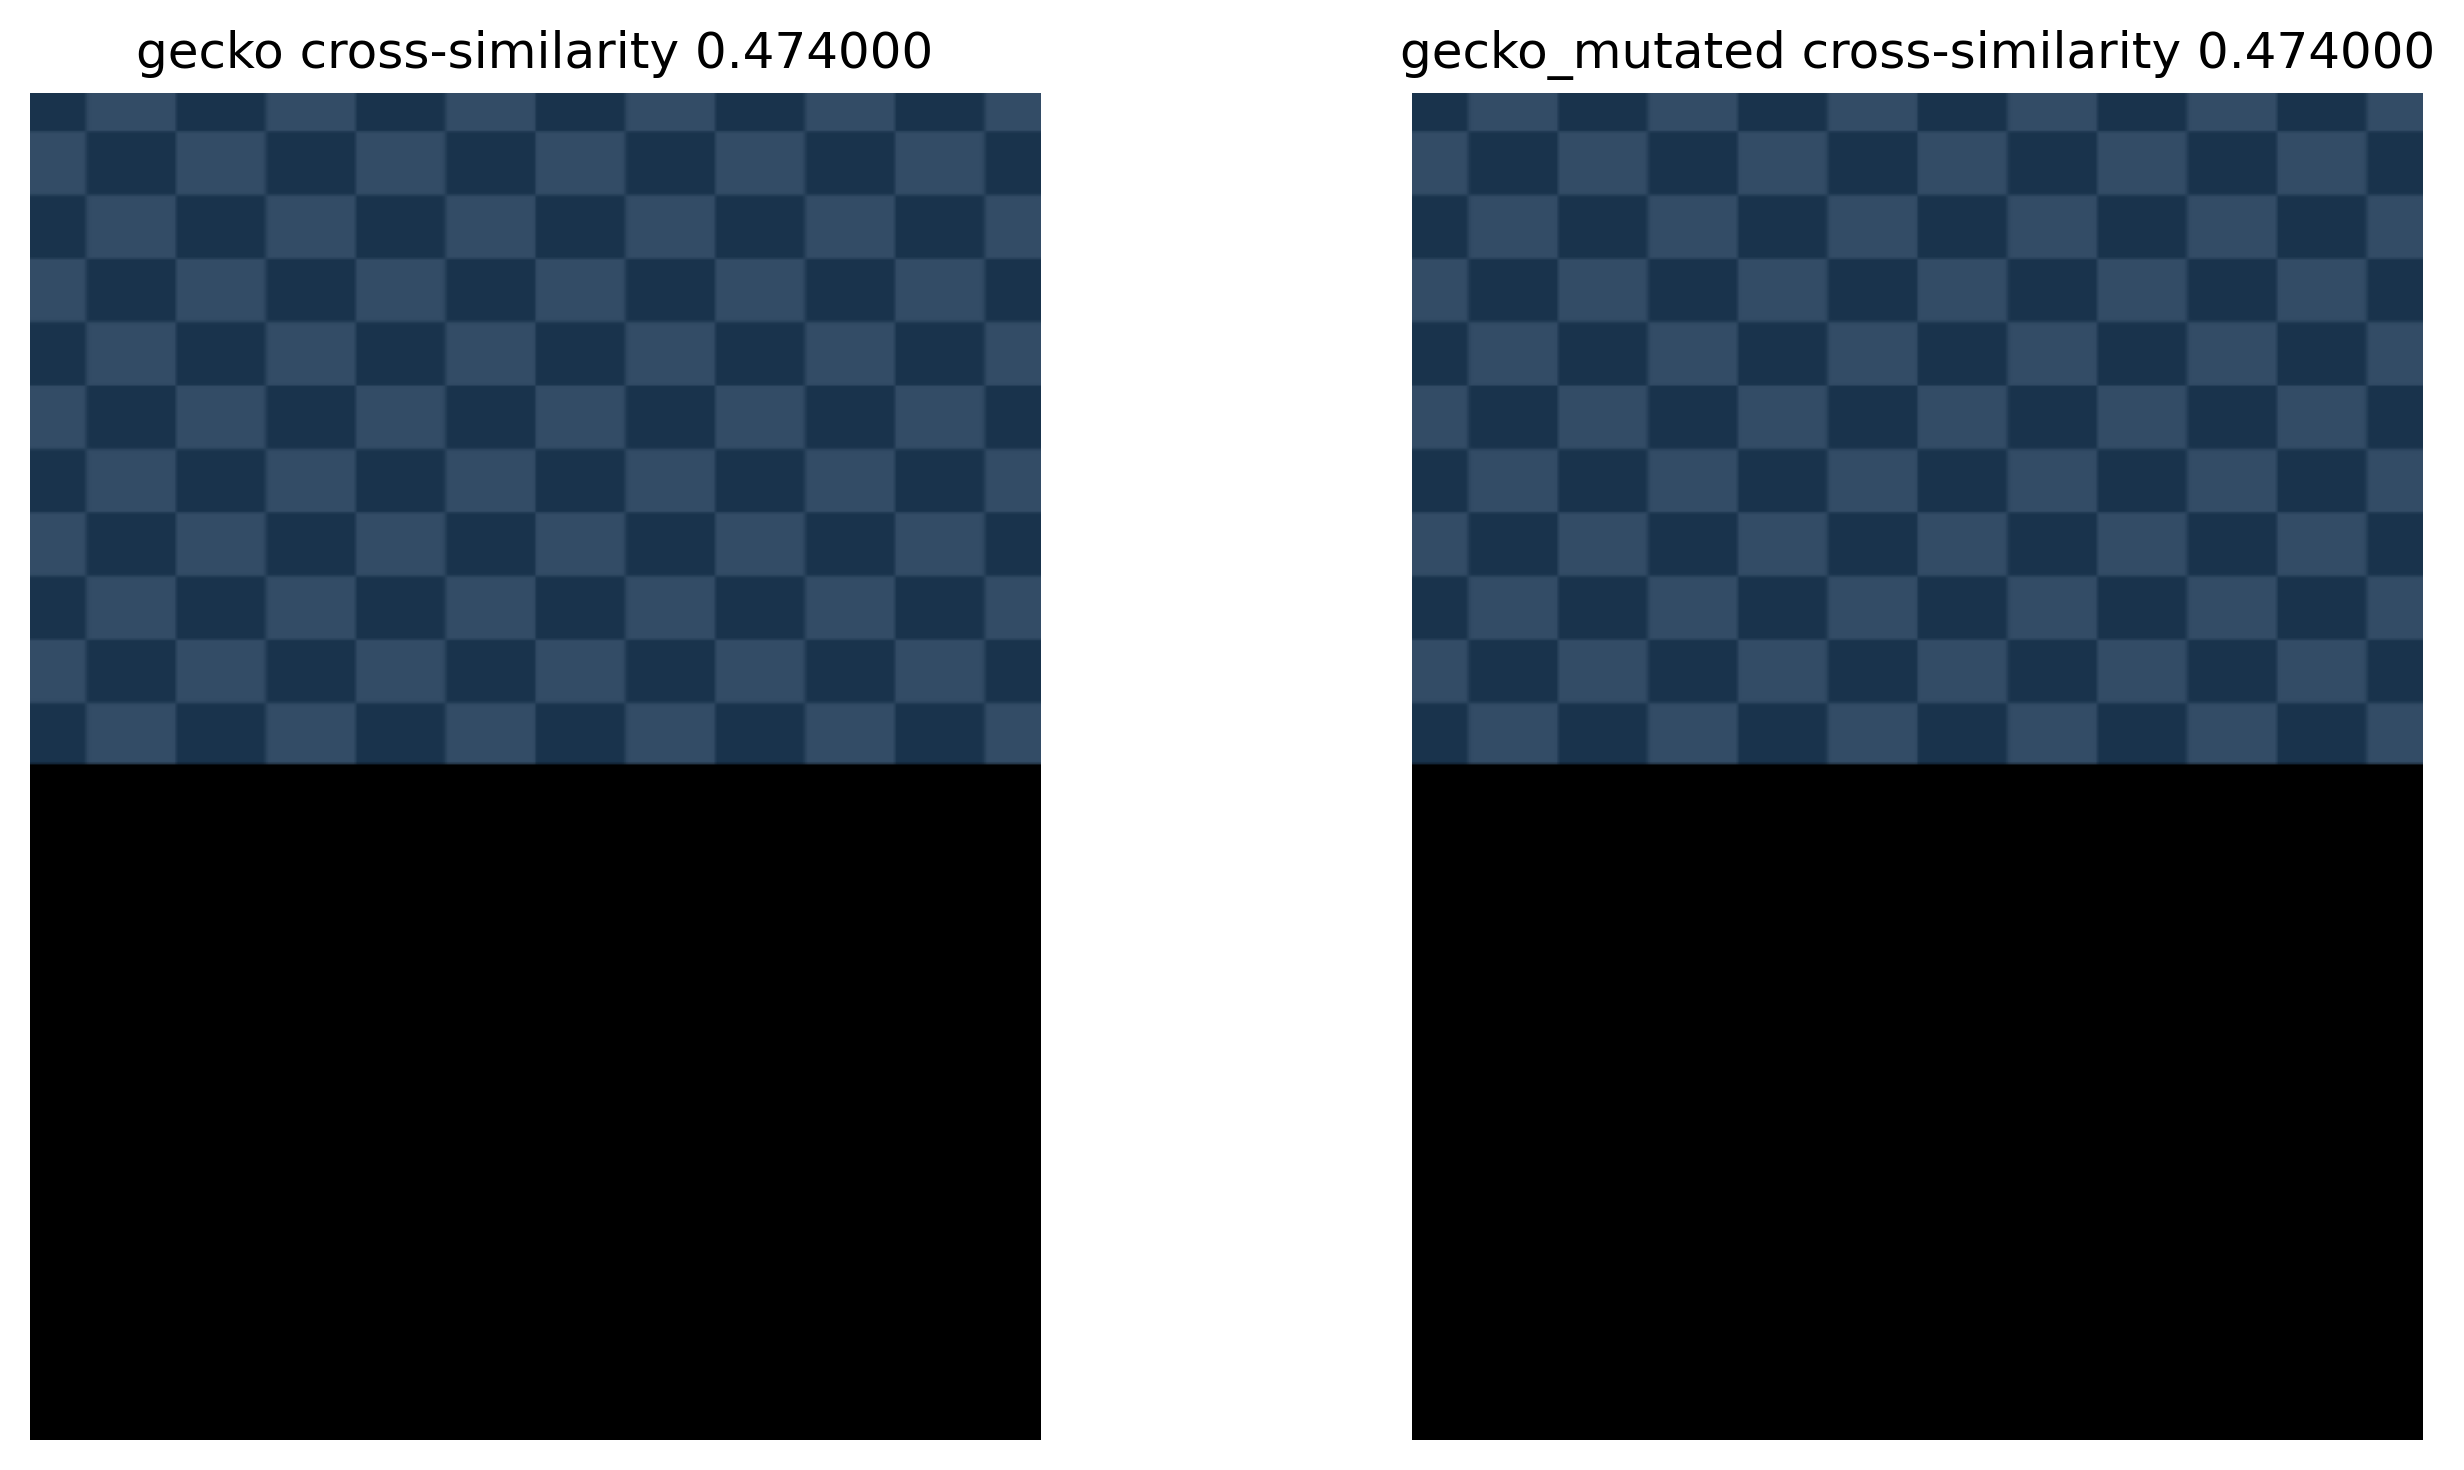

In [42]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

deletion close to leaf

In [43]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3)])]")

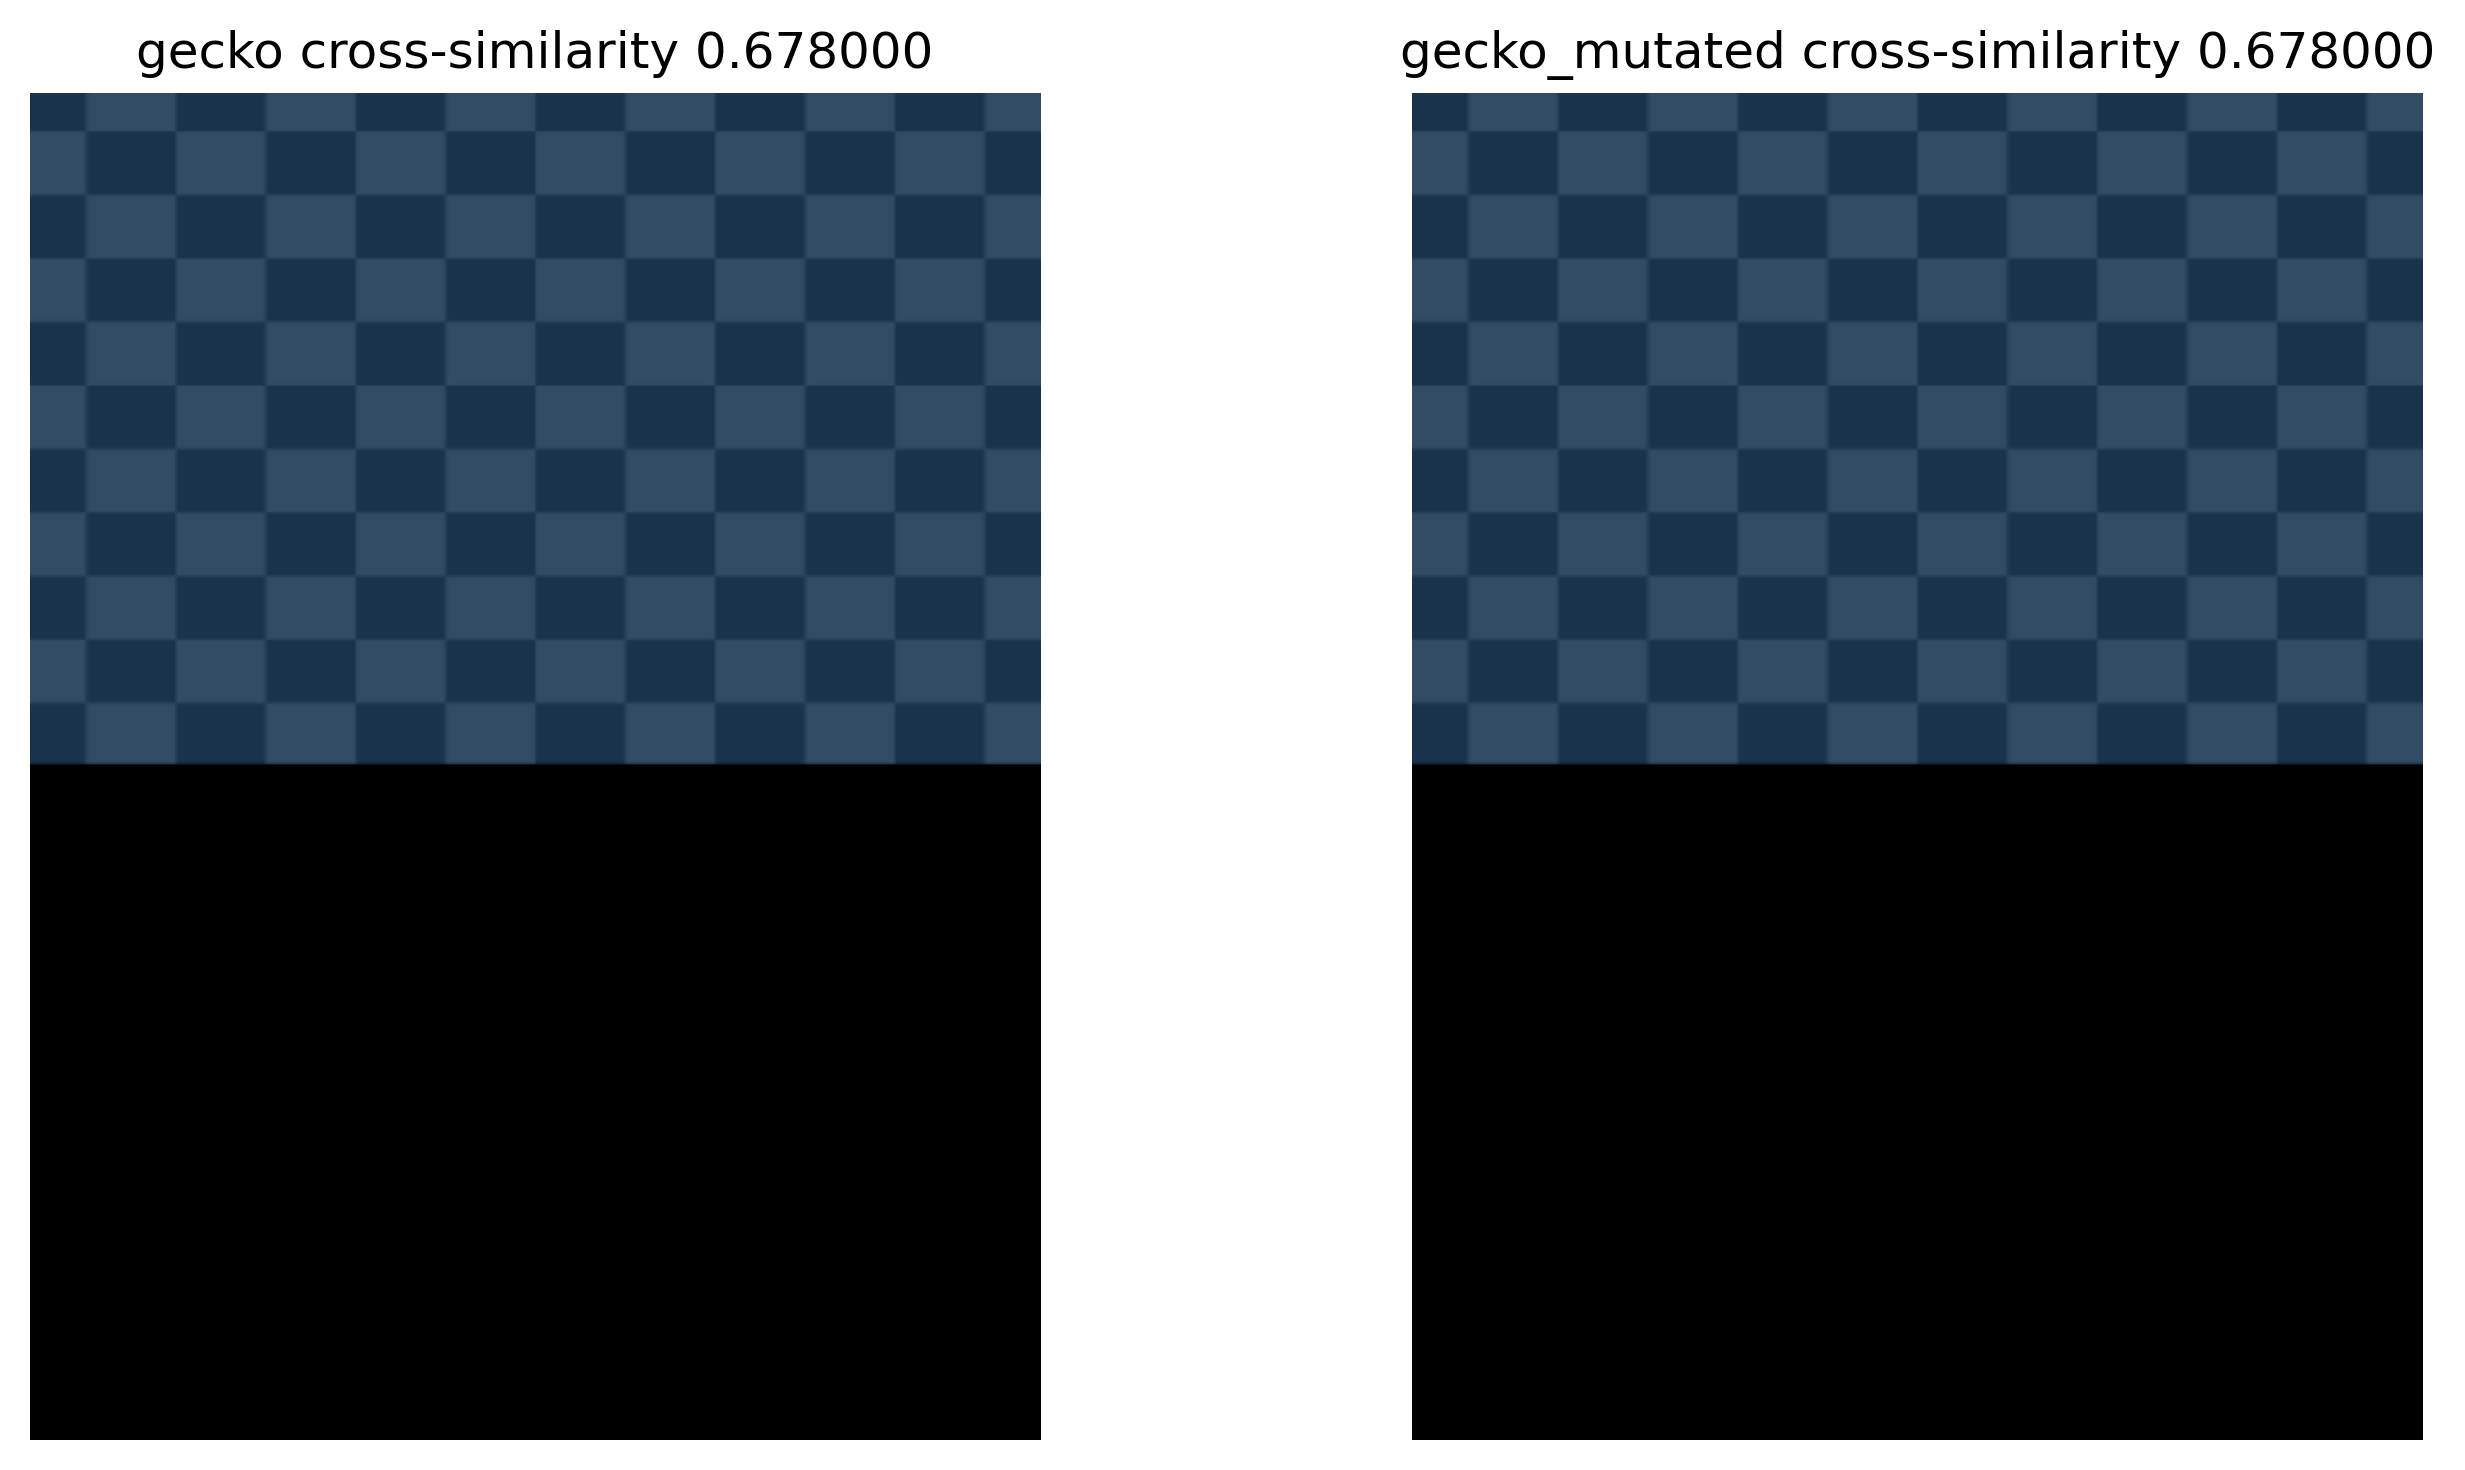

In [44]:
similarity = ctk.calculate_similarity(
    gecko, gecko_mut, config=similarity_config
)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [
        f"gecko cross-similarity {similarity:2f}",
        f"gecko_mutated cross-similarity {similarity:2f}",
    ],
)

##### nx-TED distance baseline

In [45]:
import networkx as nx

In [46]:
gecko_graph = gecko.to_graph()
gecko_mut_graph = gecko_mut.to_graph()

very slow for deletions.....

In [47]:
nx.graph_edit_distance(gecko_graph, gecko_mut_graph, timeout=1)

8.0

inaccurate for rotations or faces

-----

### Misc

##### Interactive heatmap

In [48]:
fig = go.Figure(
    data=go.Heatmap(
        z=matrix,
        colorscale="Viridis",
        hovertemplate="Row: %{y}<br>Col: %{x}<br>Value: %{z:.3f}<extra></extra>",
    )
)

fig.update_layout(
    title="Interactive Heatmap", xaxis_title="Column", yaxis_title="Row"
)
fig.show()


##### Gui for just data

In [49]:
simple_navigator = SimpleNavigator(analyzed_population.to_dict())

##### Visualize Robots

In [50]:
individual_visualizer = IndividualVisualizer(
    index_dict=analyzed_population.derived, population=population
)

##### See graphs

In [51]:
individual_visualizer = IndividualVisualizer(
    index_dict=analyzed_population.derived,
    population=population,
    visualize_fn=visualize_tree_from_graph,
)